In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns
sns.set_theme(font_scale=1.5, style = 'whitegrid', context= 'notebook')
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from itertools import product
import dash
from dash import dcc, html, Input, Output
import scipy as sp
from pybaselines import Baseline
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.special import expit
from scipy.signal import savgol_filter
from scipy.special import wofz
import math
#from pybaselines import Baseline

#oadeji01
os.chdir('c:\\Users\\oadeji01\\OneDrive - Tufts\\Bunmi - NavehLab-01\\Raman_Bunmi\\20250616')#\\fitted')\\20250609_fitted

In [286]:
df = pd.read_csv('20250616.csv').iloc[:, 1:]
#df2 = pd.read_csv('c:\\Users\\oadeji01\\OneDrive - Tufts\\Bunmi - NavehLab-01\\Raman_Bunmi\\20250609\\20250609xx.csv')
#df2.columns =  df.columns

df.insert(0, 'exp', ['20250616']*len(df))
#df2.insert(0, 'exp', ['20250609']*len(df2))


#df = pd.concat([df, df2], axis=0).reset_index(drop=True)

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_21116\3697762037.py:9: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oadeji01\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


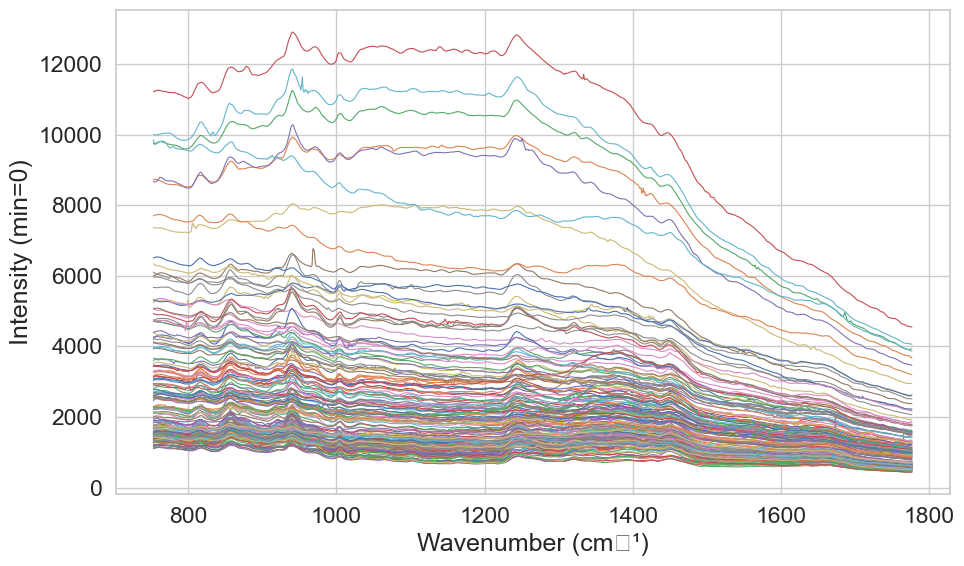

In [287]:
# Plot raw spectra

plt.figure(figsize=(10,6))
for i in range(len(df)):
    sns.lineplot(x=df.columns[5:].astype(float), y=df.iloc[i, 5:], lw=0.8)
plt.xlabel("Wavenumber (cm\u207B\u00B9)")
plt.ylabel("Intensity (min=0)")
#plt.title(f"{degree}ᵗʰ‑order baseline, {anchor_points} anchors")
plt.tight_layout()
plt.show()

### Import glass spectra

In [288]:
glass = pd.read_csv('c:\\Users\\oadeji01\\OneDrive - Tufts\\Bunmi - NavehLab-01\\Raman_Bunmi\\glass_spec.csv')
#.value
g_mean = glass.iloc[:, 1:].mean()

#interpolate glass spectrum to match spectra wavenumbers
interpolator = sp.interpolate.interp1d(g_mean[219:630].index.to_numpy(float), g_mean[219:630].values, kind = 'linear', bounds_error=False, fill_value = 0)
new_glass = interpolator(df.iloc[:, 5:].columns.to_numpy(float))

### Subtract glass contamination from spectra

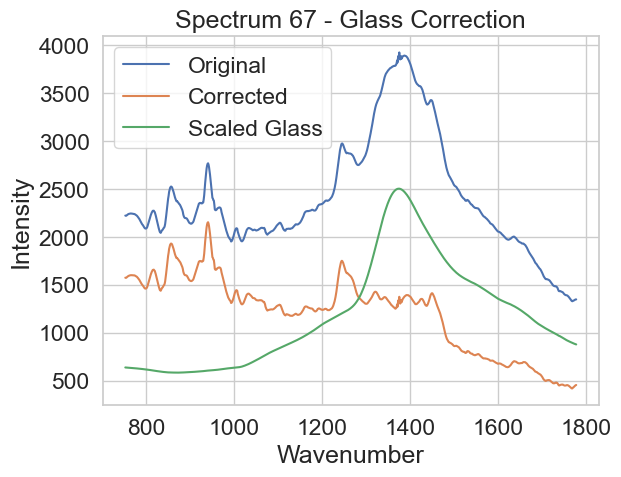

In [289]:
glass_region = (1300, 1450)  # Adjust to match your data

# --- Prepare data ---
wavenumbers = df.columns[5:].astype(float).to_numpy()
glass_ref = new_glass  # known glass reference spectrum (1D array)

# --- Select region corresponding to glass peak ---
glass_mask = (wavenumbers >= glass_region[0]) & (wavenumbers <= glass_region[1])
glass_ref_segment = glass_ref[glass_mask]

threshold_corr = 0.70      # correlation threshold
min_intensity_ratio = 0.23  # ignore weak glass signals
scaling_margin = 0.65       # scale glass to 95% of sample's max in the region

corrected_spectra = []
glass_contaminated_indices = []

for i in range(len(df)):
    y = df.iloc[i, 5:].astype(float).to_numpy()
    y_segment = y[glass_mask]

    # Step 1: Check correlation between signal and glass
    corr, _ = stats.pearsonr(y_segment, glass_ref_segment)

    # Step 2: Check intensity ratio
    max_y_segment = np.max(y_segment)
    max_glass_segment = np.max(glass_ref_segment)
    intensity_ratio = max_y_segment / (max_glass_segment + 1e-8)

    if corr > threshold_corr and intensity_ratio > min_intensity_ratio:
        # Step 3: Scale glass to be slightly lower than contaminated signal
        scale_factor = (max_y_segment / (max_glass_segment + 1e-8)) * scaling_margin
        scaled_glass = glass_ref * scale_factor

        # Step 4: Subtract glass signal
        corrected = y - scaled_glass
        corrected = np.clip(corrected, 0, None)  # ensure no negative values
        glass_contaminated_indices.append(i)
    else:
        corrected = y  # No subtraction if not contaminated

    corrected_spectra.append(corrected)

# --- Create DataFrame for corrected spectra ---
corrected_df = pd.DataFrame(corrected_spectra, columns=wavenumbers)

if glass_contaminated_indices:
    i = glass_contaminated_indices[0]
    plt.plot(wavenumbers, df.iloc[i, 5:], label='Original')
    plt.plot(wavenumbers, corrected_df.iloc[i], label='Corrected')
    plt.plot(wavenumbers, glass_ref * scale_factor, label='Scaled Glass')
    plt.title(f"Spectrum {i} - Glass Correction")
    plt.legend()
    plt.xlabel('Wavenumber')
    plt.ylabel('Intensity')
    plt.show()


C:\Users\oadeji01\AppData\Local\Temp\ipykernel_21116\4130104931.py:9: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oadeji01\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


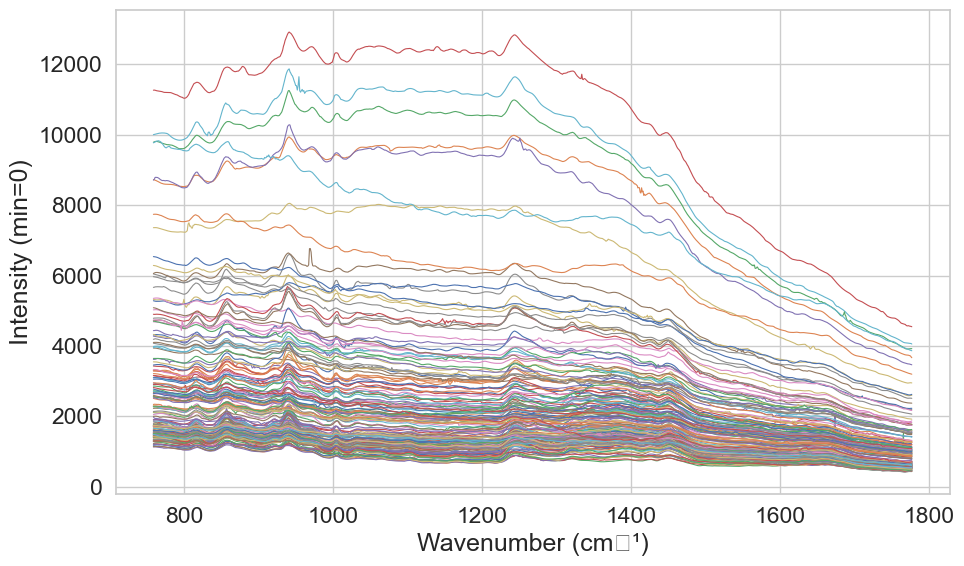

In [290]:
# Plot corrected spectra. 
# Glass contamination is removed

plt.figure(figsize=(10,6))
for i in range(len(corrected_df)):
    sns.lineplot(x=corrected_df.columns[5:].astype(float), y=corrected_df.iloc[i, 5:], lw=0.8)
plt.xlabel("Wavenumber (cm\u207B\u00B9)")
plt.ylabel("Intensity (min=0)")
plt.tight_layout()
plt.show()

#### Baseline Correction

In [291]:
#Baseline Correction Function

def baseline_poly_with_anchors(df, degree, anchor_points, regions):
    """
    df: pandas.DataFrame with spectra in rows; metadata in cols 0–3; data in cols 4: 
    degree: polynomial degree
    anchor_points: exact number of points to use for fitting
    regions: list of (low, high) tuples in same units as df.columns for background
    """
    # 1) get wavenumbers
    x_full = df.columns[4:].astype(float).to_numpy()
    n = x_full.size
    
    # 2) find all candidate indices in the union of regions
    mask = np.zeros_like(x_full, dtype=bool)
    for low, high in regions:
        mask |= (x_full >= low) & (x_full <= high)
    cand_idx = np.where(mask)[0]
    if cand_idx.size < anchor_points:
        raise ValueError(f"only {cand_idx.size} points in regions but need {anchor_points}")
    
    # 3) pick exactly `anchor_points` evenly from candidates
    pick_idx = cand_idx[np.linspace(0, cand_idx.size-1, anchor_points, dtype=int)]
    x_anchors = x_full[pick_idx]
    
    corrected_list = []
    for _, row in df.iterrows():
        y = row.iloc[4:].astype(float).to_numpy()
        y_anchors = y[pick_idx]
        
        # 4) fit and subtract
        coeffs = np.polyfit(x_anchors, y_anchors, degree)
        baseline = np.polyval(coeffs, x_full)
        y_corr = y - baseline
        
        # 5) shift minimum to zero
        y_corr -= y_corr.min()
        corrected_list.append(y_corr)
    
    # assemble result
    corrected_df = pd.DataFrame(
        corrected_list,
        index=df.index,
        columns=x_full
    )
    return corrected_df

In [292]:
# Apply baseline correction function
degree        = 5
anchor_points = 159
regions       = [(750, 752), (777, 784), (795, 805), (1009, 1020), (1110, 1120), (1143, 1156), (1215, 1226), (1500,1607), (1694,1780)]

corrected = baseline_poly_with_anchors(corrected_df.iloc[:, 5:], degree, anchor_points, regions)

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_21116\2025139441.py:7: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oadeji01\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


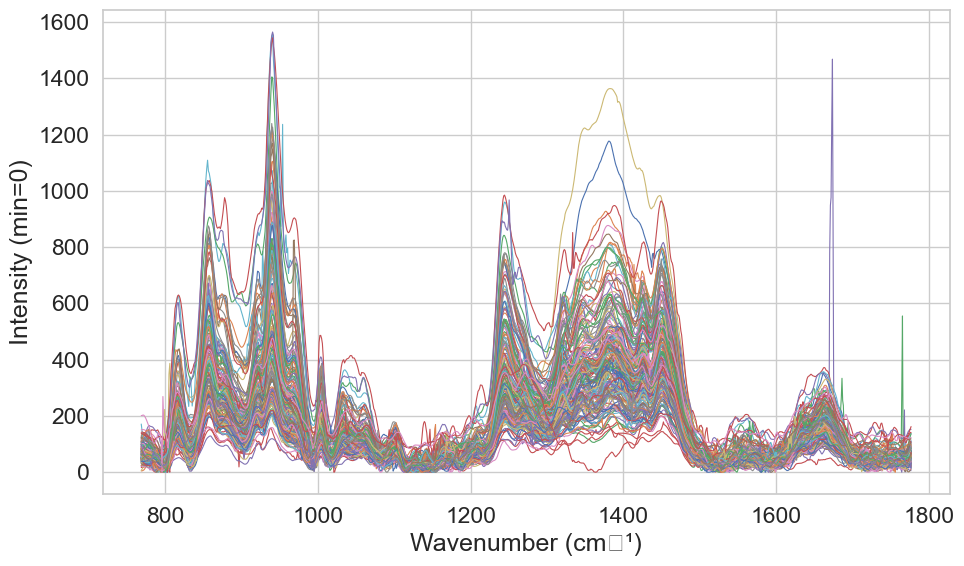

In [293]:
# Plot baseline corrected spectra
plt.figure(figsize=(10,6))
for i in range(len(corrected)):
    sns.lineplot(x=corrected.columns[5:].astype(float), y=corrected.iloc[i, 5:], lw=0.8)
plt.xlabel("Wavenumber (cm\u207B\u00B9)")
plt.ylabel("Intensity (min=0)")
plt.tight_layout()
plt.show()

In [294]:
#Save baseline corrected data
bc_df = pd.concat([df.iloc[:, :5], corrected], axis=1)
#bc_df.to_csv('20250609_blc.csv', index=False)

### Spectra Smoothing: SavGol Smoothing

In [295]:
rmse1 = []
for w in range(10, 36, 2):
    for p in range(2, 5):
    #print(w)
      for x in range(len(df)):
          
          spectrum = bc_df.iloc[x, 5:].to_numpy(dtype=float)
          #print(spectrum)
          smoothed = sp.signal.savgol_filter(x= spectrum, window_length=w, polyorder=p)
          #print(smoothed)
          rmse = np.sqrt(np.mean((spectrum - smoothed) **2))
          rel_rmse = (rmse/np.max(spectrum))*100
          #print(rmse)

          rmse1.append({'sample':df.loc[x, 'sample'],
                        'trt_time':df.loc[x, 'trt_time'],
                        'orient':df.loc[x, 'orient'],
                          'window': w,
                          'polynomial': p,
                      'rmse': rmse,
                      'rel_rmse': rel_rmse})

In [296]:
rmse_window = pd.concat([pd.DataFrame(rmse1)], axis=1)
#rmse_window

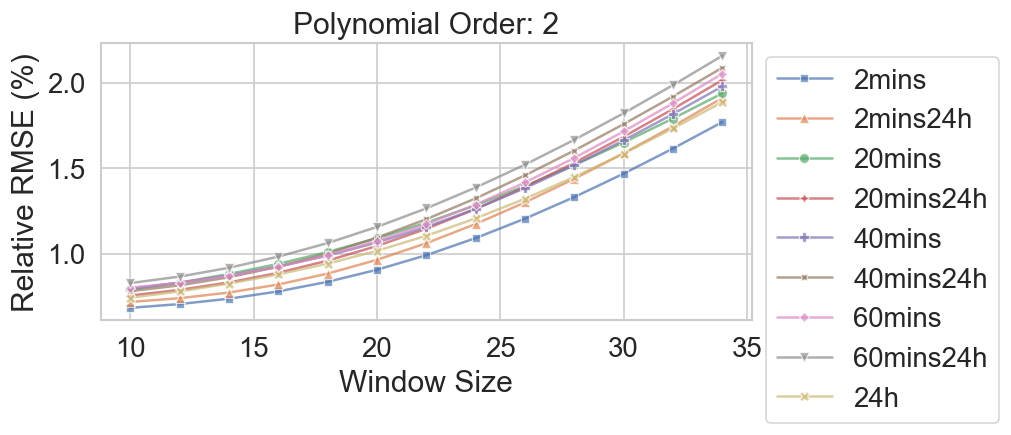

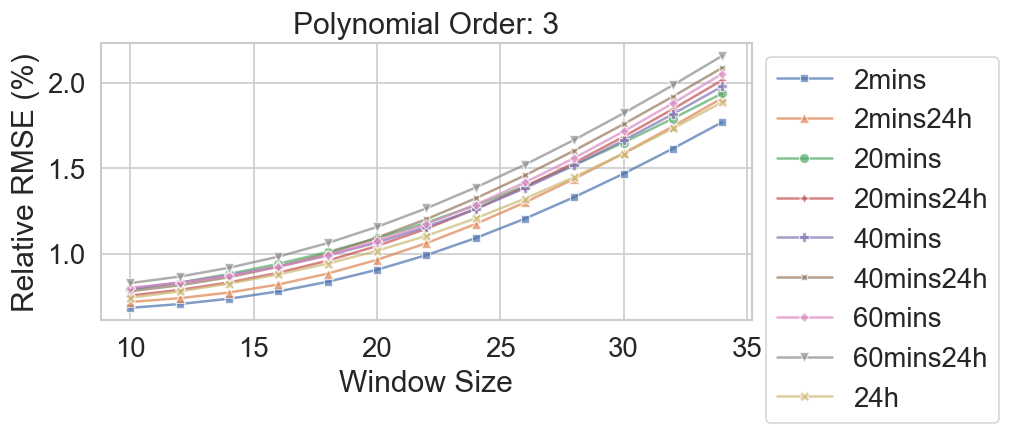

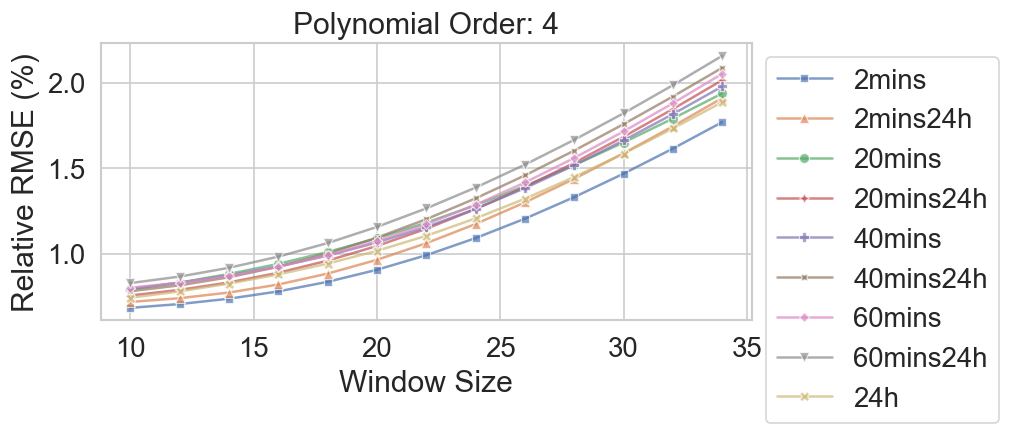

In [298]:
for p in rmse_window['polynomial'].unique():
    plt.figure(figsize = (7, 3), dpi = 120);

    sns.lineplot(
        x = 'window',
        y = 'rel_rmse',
        data=rmse_window,
        markers=True,
        hue = 'trt_time',
        hue_order=['2mins', '2mins24h','20mins','20mins24h','40mins', '40mins24h','60mins', '60mins24h', '24h'], 
        style = 'trt_time',
        #style_order=['2mins', '2min24h','20mins','20min24h','40mins', '40min24h','60mins', '60min24h', '24h'], 
        dashes = False,
        errorbar=None,
        alpha = .7,
        #err_style = 'bars'
    );
    plt.legend(bbox_to_anchor = (1, 1));
    plt.title(f'Polynomial Order: {p}');
    plt.ylabel('Relative RMSE (%)')
    plt.xlabel('Window Size')

In [299]:
# Smooth based on chosen window size

smoothed_list = []
for x in range(len(bc_df.iloc[:, 5:])):
    smoothed_list.append(sp.signal.savgol_filter(x= bc_df.iloc[x, 5:], window_length=20, polyorder=3))

smoothed_df = pd.DataFrame(smoothed_list, columns=bc_df.iloc[:, 5:].columns)
smoothed_df = pd.concat([df.iloc[:, :5], smoothed_df], axis=1)

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_21116\3313300378.py:7: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oadeji01\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


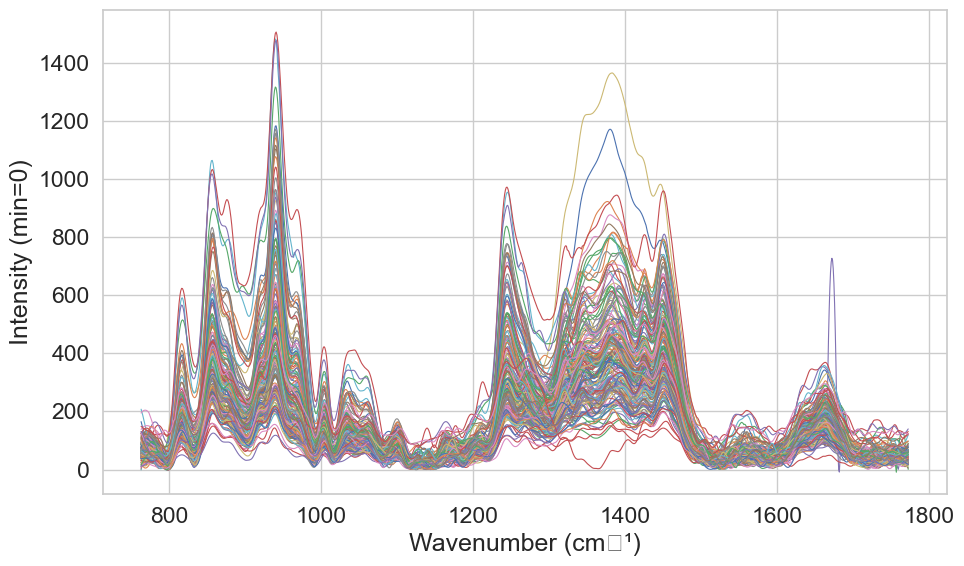

In [300]:
plt.figure(figsize=(10,6))
for i in range(len(smoothed_df)):
    sns.lineplot(x=smoothed_df.columns[5:-5].astype(float), y=smoothed_df.iloc[i, 5:-5], lw=0.8)
plt.xlabel("Wavenumber (cm\u207B\u00B9)")
plt.ylabel("Intensity (min=0)")
#plt.title(f"{degree}ᵗʰ‑order baseline, {anchor_points} anchors")
plt.tight_layout()
plt.show()

#### Plot the Raw and Smoothed Data

In [301]:
smoothed_list = []
for x in range(len(bc_df.iloc[:, 5:])):
    smoothed_list.append(sp.signal.savgol_filter(x= bc_df.iloc[x, 5:], window_length=15, polyorder=3))

smoothed_df = pd.DataFrame(smoothed_list, columns=bc_df.iloc[:, 5:].columns)
smoothed_df = pd.concat([df.iloc[:, :5], smoothed_df], axis=1)

In [ ]:
# Save smoothed data
smoothed_df.to_csv('20250609_smoothed.csv')

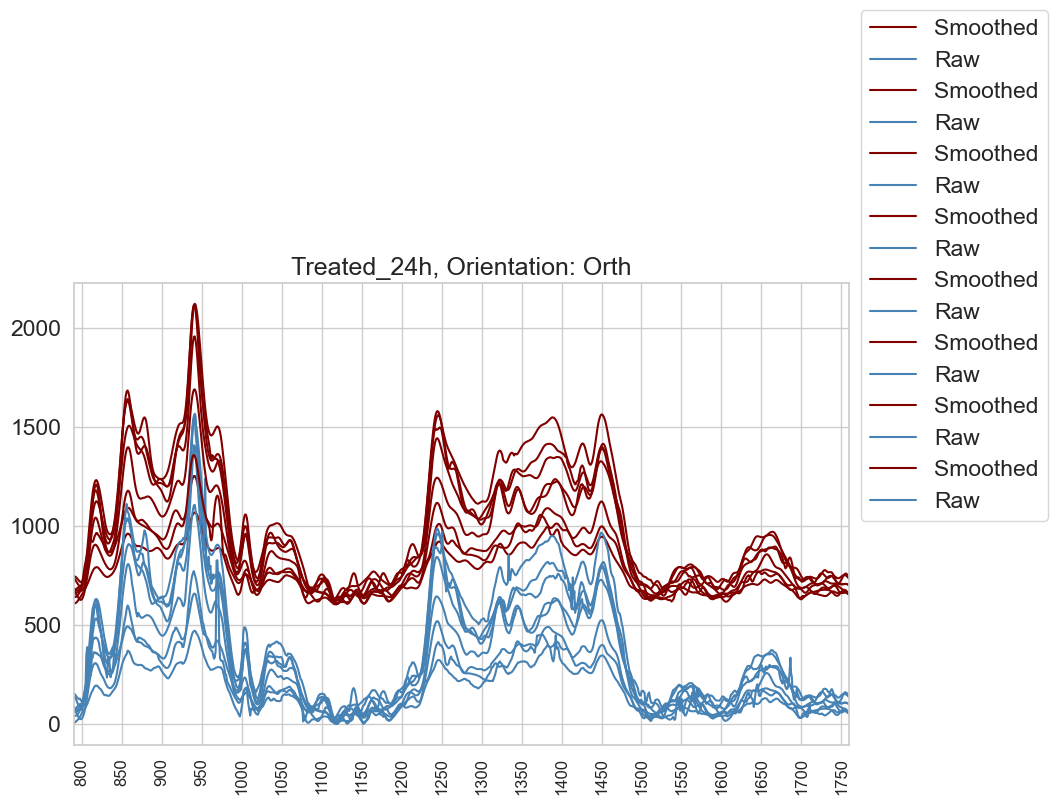

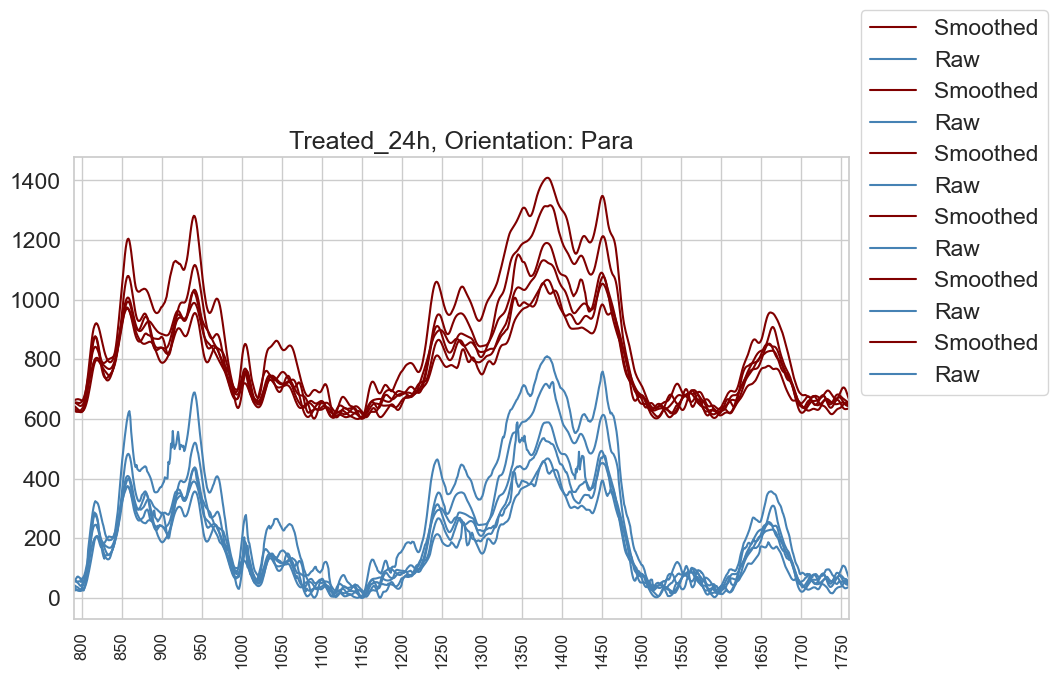

In [303]:
for x in df['orient'].unique():
    plt.figure(figsize = (10, 6))
    for y in range(len(smoothed_df[(smoothed_df['sample']=='Trt')&(smoothed_df['trt_time']=='24h')&(smoothed_df['orient']==x)])):
        
        sns.lineplot(
            x = smoothed_df[(smoothed_df['sample']=='Trt')&(smoothed_df['trt_time']=='24h')&(smoothed_df['orient']==x)].iloc[y, 5:-1].index.to_numpy(float),
            y = smoothed_df[(smoothed_df['sample']=='Trt')&(smoothed_df['trt_time']=='24h')&(smoothed_df['orient']==x)].iloc[y, 5:-1].values+600,#[0] ,#
            label = 'Smoothed',
            color = 'maroon'
        )
        sns.lineplot(
            x = bc_df[(bc_df['sample']=='Trt')&(bc_df['trt_time']=='24h')&(bc_df['orient']==x)].iloc[y, 5:-1].index.to_numpy(float),
            y = bc_df[(bc_df['sample']=='Trt')&(bc_df['trt_time']=='24h')&(bc_df['orient']==x)].iloc[y, 5:-1].values,#[0],
            label = 'Raw',
            color = 'steelblue'
        )
        plt.title(f'Treated_24h, Orientation: {x}')
        plt.xlim(790, 1760)
        plt.xticks(ticks=np.arange(800, 1800, 50), fontsize =  12, rotation = 90, ha = 'center');
    plt.legend(bbox_to_anchor = (1, .46));

In [304]:
raw_mean = bc_df.groupby(['sample', 'trt_time', 'orient']).mean(numeric_only = True).reset_index()
smooth_mean = smoothed_df.groupby(['sample', 'trt_time', 'orient']).mean(numeric_only = True).reset_index()

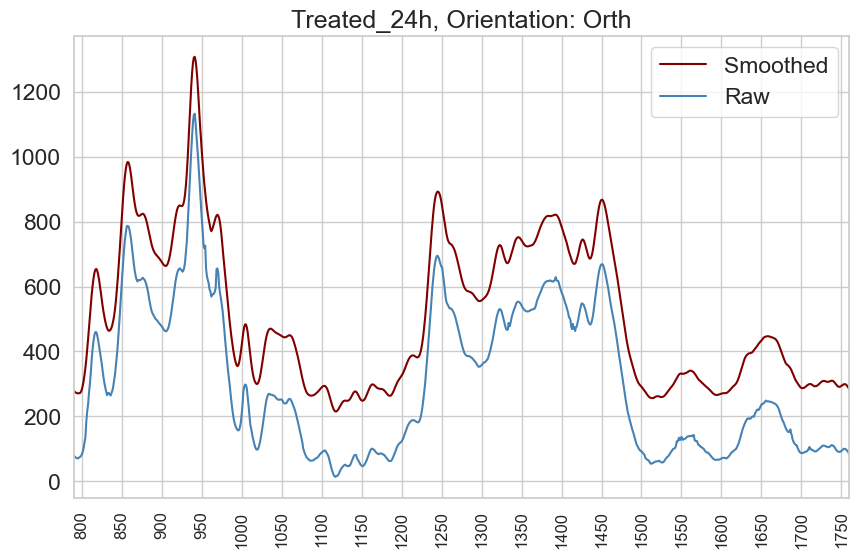

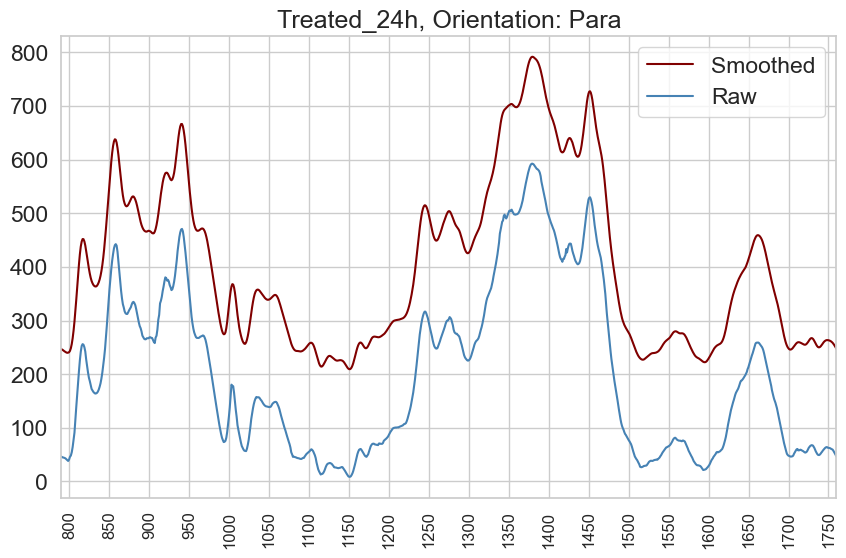

In [305]:
for x in df['orient'].unique():
    plt.figure(figsize = (10, 6))
    sns.lineplot(
        x = smooth_mean[(smooth_mean['sample']=='Trt')&(smooth_mean['trt_time']=='24h')&(smooth_mean['orient']==x)].iloc[:, 4:].columns.to_numpy(float),
        y = smooth_mean[(smooth_mean['sample']=='Trt')&(smooth_mean['trt_time']=='24h')&(smooth_mean['orient']==x)].iloc[:, 4:].values[-1] +200,
        label = 'Smoothed',
        color = 'maroon'
    )
    sns.lineplot(
        x = raw_mean[(raw_mean['sample']=='Trt')&(raw_mean['trt_time']=='24h')&(raw_mean['orient']==x)].iloc[:, 4:].columns.to_numpy(float),
        y = raw_mean[(raw_mean['sample']=='Trt')&(raw_mean['trt_time']=='24h')&(raw_mean['orient']==x)].iloc[:, 4:].values[0],
        label = 'Raw',
        color = 'steelblue'
    )
    plt.title(f'Treated_24h, Orientation: {x}')
    plt.xlim(790, 1760)
    plt.xticks(ticks=np.arange(800, 1800, 50), fontsize =  12, rotation = 90, ha = 'center');

### Peak Fit


# --- Gaussian Function ---
def gaussian(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

def lorentzian(x, A, x0, gamma):
    return A / (1 + ((x - x0) / gamma)**2)

def estimate_sigma_from_fwhm(x, y):
    half_max = np.max(y) / 2
    indices = np.where(y >= half_max)[0]
    if len(indices) >= 2:
        fwhm = x[indices[-1]] - x[indices[0]]
        return fwhm / 2.355
    else:
        return (x[-1] - x[0]) / 6  # fallback

def fit_lorentzian(x, y):
    # Initial guesses
    A_guess = np.max(y)
    x0_guess = x[np.argmax(y)]
    gamma_guess = (x[-1] - x[0]) / 10  # a reasonable initial HWHM

    try:
        popt, pcov = curve_fit(lorentzian, x, y, p0=[A_guess, x0_guess, gamma_guess])
        A, x0, gamma = popt
        fit_y = lorentzian(x, A, x0, gamma)
        return {
            'amplitude': A,
            'center': x0,
            'gamma': gamma,
            'fit_curve': fit_y
        }
    except RuntimeError:
        print("Fit failed.")
        return None

# --- Fit Gaussian to One Spectrum ---
def fit_peaks_from_row(row, wavenumbers, region=None, guess=None, plot=False):
    x = wavenumbers.astype(float)
    y = row[wavenumbers].values.astype(float)

    if region:
        mask = (x >= region[0]) & (x <= region[1])
        x = x[mask]
        y = y[mask]
        #print(len(x), len(y))
        #print(x, y)
    # If no data in the region, return NaN values
    if len(x) == 0 or len(y) == 0:
        return pd.Series({"Amplitude": np.nan, "Center": np.nan, "Width (FWHM)": np.nan, "Area": np.nan})

    if guess is None:
        A_guess = np.max(y)
        x0_guess = x[np.argmax(y)]
        # In your fit function:
        sigma_guess = estimate_sigma_from_fwhm(x, y)
        # sigma_guess = (x[-1] - x[0]) / 6
        guess = (A_guess, x0_guess, sigma_guess)

    try:
        popt, _ = curve_fit(gaussian, x, y, p0=guess)
        A, x0, sigma = popt
        area = A * sigma * np.sqrt(2 * np.pi)
        width = 2.355 * sigma  # FWHM

        if plot:
            plt.plot(x, y, label="Data")
            plt.plot(x, gaussian(x, *popt), label="Fit", linestyle="--")
            plt.legend()
            plt.title(f"Fit at row index {row.name}")
            plt.xlabel("Wavenumber")
            plt.ylabel("Intensity")
            plt.show()

        return pd.Series({
            "Amplitude": A,
            "Center": x0,
            "Width (FWHM)": width,
            "Area": area
        })

    except Exception as e:
        return pd.Series({"Amplitude": np.nan, "Center": np.nan, "Width (FWHM)": np.nan, "Area": np.nan})




def fit_peaks_from_row(row_index, df, x_range=None, plot=False):
    """
    Fit a Lorentzian peak to a specific row in the DataFrame.

    Parameters:
    - row_index: Index of the row in the DataFrame to fit.
    - df: DataFrame with spectral data; x-values should be columns (except first few).
    - x_range: Tuple (min_x, max_x) to restrict fitting range.
    - plot: Whether to plot the fit.

    Returns:
    - Dictionary with fit parameters or None if fit fails.
    """
    # Extract spectral data
    y = df.iloc[row_index, 5:].astype(float).values
    x = df.columns[5:].astype(float).values

    # Filter by x_range if provided
    if x_range:
        mask = (x >= x_range[0]) & (x <= x_range[1])
        x = x[mask]
        y = y[mask]

    # Avoid fitting if x or y is empty
    if len(x) == 0 or len(y) == 0:
        print(f"No data in range for row {row_index}")
        return None

    # Initial guesses
    A_guess = np.max(y)
    x0_guess = x[np.argmax(y)]
    gamma_guess = (x[-1] - x[0]) / 10

    try:
        popt, _ = curve_fit(lorentzian, x, y, p0=[A_guess, x0_guess, gamma_guess])
        A, x0, gamma = popt
        fit_y = lorentzian(x, A, x0, gamma)

        if plot:
            plt.figure(figsize=(6, 5))
            plt.plot(x, y, label='Data', linewidth=2)
            plt.plot(x, fit_y, '--', label='Lorentzian Fit', linewidth=2)
            plt.xlabel('Wavenumber')
            plt.ylabel('Intensity')
            plt.title(f'Fit at row index {row_index}')
            plt.legend()
            plt.tight_layout()
            plt.show()

        return {
            'amplitude': A,
            'center': x0,
            'gamma': gamma,
            'fit_curve': fit_y
        }

    except RuntimeError:
        print(f"Fit failed at row {row_index}")
        return None

def voigt(x, A, x0, sigma, gamma):
    """
    Voigt profile function.
    
    Parameters:
    - A: amplitude
    - x0: center position
    - sigma: Gaussian std deviation
    - gamma: Lorentzian half-width at half-maximum
    
    Returns:
    - Voigt profile evaluated at x
    """
    z = ((x - x0) + 1j*gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

def fit_voigt_from_row(row_index, df, x_range=None, plot=False): 
    """
    Fit a Voigt peak to a specific row in the DataFrame.

    Parameters:
    - row_index: Index of the row in the DataFrame to fit.
    - df: DataFrame with spectral data; x-values should be columns (except first few).
    - x_range: Tuple (min_x, max_x) to restrict fitting range.
    - plot: Whether to plot the fit.

    Returns:
    - Dictionary with fit parameters or None if fit fails.
    """
    # Extract spectral data
    y = df.iloc[row_index, 5:].astype(float).values
    x = df.columns[5:].astype(float).values

    # Filter by x_range if provided
    if x_range:
        mask = (x >= x_range[0]) & (x <= x_range[1])
        x = x[mask]
        y = y[mask]

    # Avoid fitting if x or y is empty
    if len(x) == 0 or len(y) == 0:
        print(f"No data in range for row {row_index}")
        return None

    # Initial guesses
    A_guess = np.max(y)
    x0_guess = x[np.argmax(y)]
    sigma_guess = (x[-1] - x[0]) / 20
    gamma_guess = (x[-1] - x[0]) / 20

    try:
        bounds = ([0, x[0], 0, 0], [np.inf, x[-1], np.inf, np.inf])
        popt, _ = curve_fit(voigt, x, y, p0=[A_guess, x0_guess, sigma_guess, gamma_guess], bounds = bounds)
        A, x0, sigma, gamma = popt
        fit_y = voigt(x, *popt)

        if plot:
            plt.figure(figsize=(6, 5))
            plt.plot(x, y, label='Data', linewidth=2)
            plt.plot(x, fit_y, '--', label='Voigt Fit', linewidth=2)
            plt.xlabel('Wavenumber')
            plt.ylabel('Intensity')
            plt.title(f'Voigt Fit at row index {row_index}')
            plt.legend()
            plt.tight_layout()
            plt.show()

        return {
            'amplitude': A,
            'center': x0,
            'sigma': sigma,
            'gamma': gamma,
            'fit_curve': fit_y
        }

    except RuntimeError:
        print(f"Fit failed at row {row_index}")
        return None

In [397]:
# Define Voigt function
def voigt(x, A, x0, sigma, gamma, offset):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi)) + offset

# Fit function with optional fixed true_center
def fit_peaks_from_row(row_index, df, region=None, guess=None, true_center=None, plot=False):
    y = df.iloc[row_index, 5:].astype(float).values
    x = df.columns[5:].astype(float).values

    if region:
        mask = (x >= region[0]) & (x <= region[1])
        x = x[mask]
        y = y[mask]

    if len(x) == 0 or len(y) == 0:
        return pd.Series({
            "Amplitude": np.nan,
            "Center": np.nan,
            "Sigma": np.nan,
            "Gamma": np.nan,
            "Area": np.nan
        })

    # Estimate initial parameters
    if guess is None:
        A_guess = np.max(y) - np.min(y)
        x0_guess = true_center if true_center is not None else x[np.argmax(y)]
        sigma_guess = (x[-1] - x[0]) / 6
        gamma_guess = sigma_guess / 2
        offset_guess = np.min(y)
        guess = (A_guess, x0_guess, sigma_guess, gamma_guess, offset_guess)

    try:
        lower_bounds = [0, x[0], 1e-3, 1e-3, -np.inf]
        upper_bounds = [np.inf, x[-1], np.ptp(x), np.ptp(x), np.inf]
        popt, _ = curve_fit(voigt, x, y, p0=guess, bounds=(lower_bounds, upper_bounds), maxfev=10000)
        A, x0, sigma, gamma, offset = popt

        # Area approximation of Voigt using peak height and width
        area = A * (sigma + gamma) * np.sqrt(2 * np.pi)

        if plot:
            plt.figure(figsize=(6, 4))
            plt.plot(x, y, label="Data", linewidth=2)
            plt.plot(x, voigt(x, *popt), label="Voigt Fit", linestyle="--", color='orangered', linewidth=2)
            plt.title(f"Fit at row index {row_index}")
            plt.xlabel("Wavenumber")
            plt.ylabel("Intensity")
            plt.legend()
            plt.tight_layout()
            plt.show()

        return pd.Series({
            "Amplitude": A,
            "Center": x0,
            "Sigma": sigma,
            "Gamma": gamma,
            "Area": area
        })

    except Exception as e:
        print(f"Fit error: {e}")
        return pd.Series({
            "Amplitude": np.nan,
            "Center": np.nan,
            "Sigma": np.nan,
            "Gamma": np.nan,
            "Area": np.nan
        })


In [403]:
fit_results = []
for id, x in smoothed_df.iterrows():#[smoothed_df.columns[5:]].iterrows():
    #print(x.index[5:])
    results = fit_peaks_from_row(id, smoothed_df, region=(1600, 1700), true_center = 1663, plot=False)
    fit_results.append(results)

In [404]:
peak_fit = pd.concat([smoothed_df.iloc[:, :5], pd.DataFrame(fit_results)], axis=1)
#peak_fit.insert(10, 'peak_area', [sum(x) for x in peak_fit['fit_curve']])
peak_fit.head()

exp sample trt_time orient  spectra_num    Amplitude       Center  \
0  20250616   Ctrl   20mins   Orth            1  8552.413428  1655.852705   
1  20250616   Ctrl   20mins   Orth            2  3019.077965  1660.253274   
2  20250616   Ctrl   20mins   Orth            3  7483.455892  1651.819862   
3  20250616   Ctrl   20mins   Orth            4  6637.855989  1648.635258   
4  20250616   Ctrl   20mins   Orth            5  5842.309805  1672.735844   

       Sigma  Gamma           Area  
0  31.708500  0.001  679779.434214  
1  20.930254  0.001  158401.579822  
2  31.756078  0.001  595706.952873  
3  30.934794  0.001  514729.467626  
4   2.712650  0.001   39740.048459

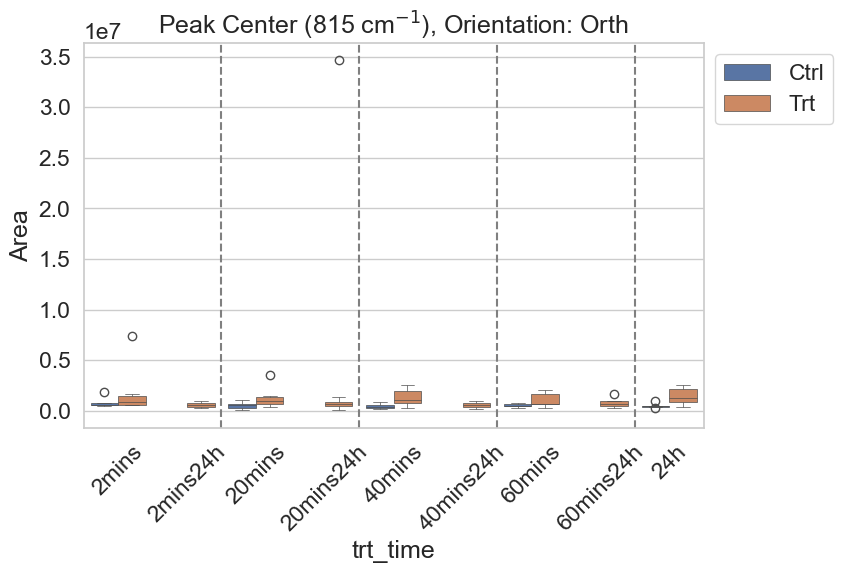

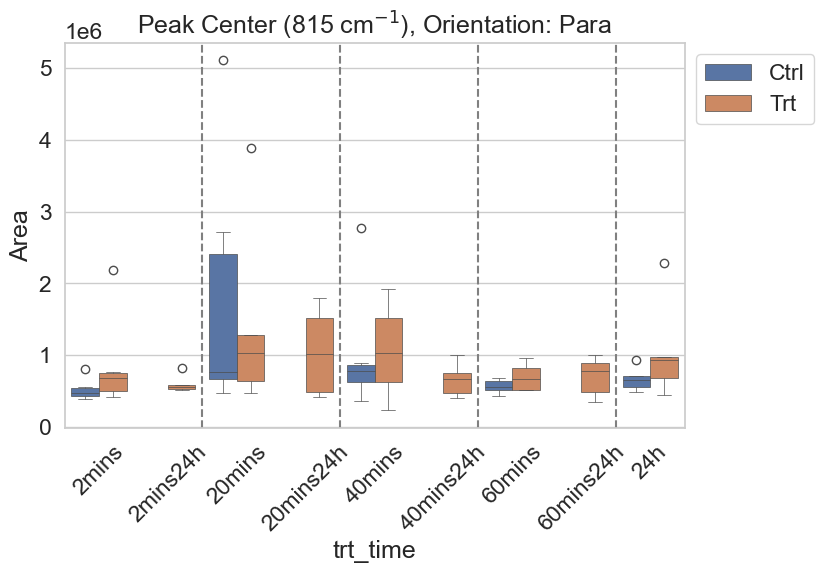

In [405]:
for x in peak_fit['orient'].unique():
    plt.figure(figsize = (8, 5))
    sns.boxplot(
        x = 'trt_time',
        y = 'Area',
        data = peak_fit[peak_fit['orient'] == x],
        hue = 'sample',
        order = ['2mins', '2mins24h','20mins','20mins24h','40mins', '40mins24h','60mins', '60mins24h', '24h'],
    # jitter = .3,
        dodge = True,
        #edgecolor = 'gray',
        linewidth = .5
    )
    #plt.ylim(810, 825)
    plt.xticks(rotation = 45, ha = 'center')
    plt.legend(bbox_to_anchor = (1, 1))
    plt.title(f'Peak Center (815 cm$^{{-1}}$), Orientation: {x}')
    for i in [1.5, 3.5, 5.5, 7.5]:
        plt.axvline(x = i, color = 'gray', ls = '--')

In [411]:
fit_results = []
for id, x in smooth_mean.iterrows():#[smoothed_df.columns[5:]].iterrows():
    #print(x.index[5:])
    results = fit_peaks_from_row(id, smoothed_df, region=(1600, 1700), true_center = 1663, plot=False)
    fit_results.append(results)

In [408]:
peak_fit_mean = pd.concat([smooth_mean.iloc[:, :5], pd.DataFrame(fit_results)], axis=1)
#peak_fit_mean.insert(10, 'peak_area', [sum(x) for x in peak_fit_mean['fit_curve']])
peak_fit_mean.head()

sample trt_time orient  spectra_num    763.177    Amplitude       Center  \
0   Ctrl   20mins   Orth     3.500000  50.370586  8552.413428  1655.852705   
1   Ctrl   20mins   Para     4.428571  79.422293  3019.077965  1660.253274   
2   Ctrl      24h   Orth     3.500000  79.850747  7483.455892  1651.819862   
3   Ctrl      24h   Para     3.500000  78.466940  6637.855989  1648.635258   
4   Ctrl    2mins   Orth     3.500000  68.670304  5842.309805  1672.735844   

       Sigma  Gamma           Area  
0  31.708500  0.001  679779.434214  
1  20.930254  0.001  158401.579822  
2  31.756078  0.001  595706.952873  
3  30.934794  0.001  514729.467626  
4   2.712650  0.001   39740.048459

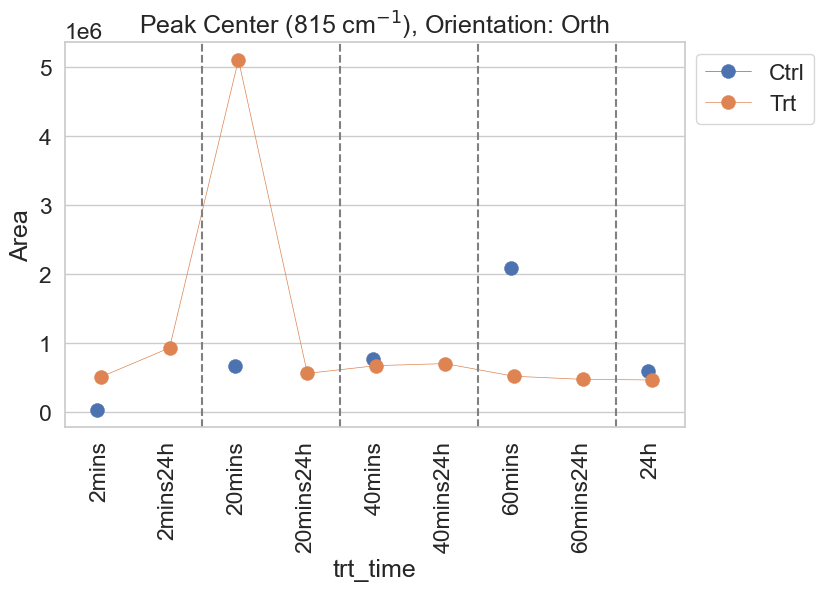

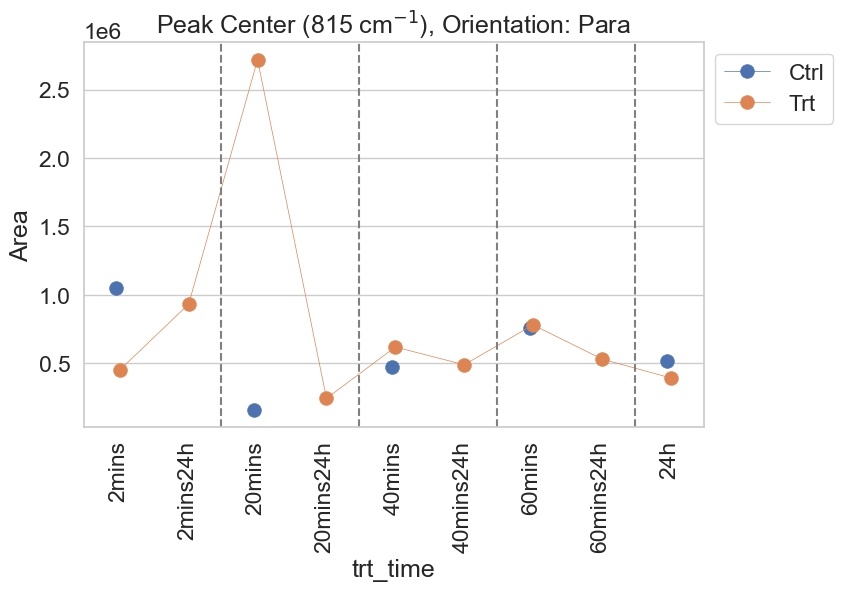

In [409]:
for x in peak_fit['orient'].unique():
    plt.figure(figsize = (8, 5))
    sns.pointplot(
        x = 'trt_time',
        y = 'Area',
        data = peak_fit_mean[peak_fit_mean['orient'] == x],
        hue = 'sample',
        order = ['2mins', '2mins24h','20mins','20mins24h','40mins', '40mins24h','60mins', '60mins24h', '24h'],
    # jitter = .3,
        dodge = True,
        #edgecolor = 'gray',
        linewidth = .5, 
        markersize=10
    )
    #plt.ylim(810, 825)
    plt.xticks(rotation = 90, ha = 'center')
    plt.legend(bbox_to_anchor = (1, 1))
    plt.title(f'Peak Center (815 cm$^{{-1}}$), Orientation: {x}')
    for i in [1.5, 3.5, 5.5, 7.5]:
        plt.axvline(x = i, color = 'gray', ls = '--')

In [433]:


# Voigt profile function
def voigt(x, A, x0, sigma, gamma, offset):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi)) + offset

# Composite Voigt model for multiple peaks
def multi_voigt(x, *params):
    n = len(params) // 5
    y = np.zeros_like(x)
    for i in range(n):
        A, x0, sigma, gamma, offset = params[i*5:(i+1)*5]
        z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
        y += A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi)) + offset
    return y

# Estimate guesses for multiple peaks
def guess_multiple_peaks(x, y, num_peaks=2):
    peaks, _ = find_peaks(y, distance=10)
    peak_positions = x[peaks]
    peak_heights = y[peaks]
    
    idx = np.argsort(peak_heights)[-num_peaks:]
    guess = []
    for i in idx:
        A = peak_heights[i] - np.min(y)
        x0 = peak_positions[i]
        sigma = (x[-1] - x[0]) / 10
        gamma = sigma / 2
        offset = np.min(y)
        guess.extend([A, x0, sigma, gamma, offset])
    return guess

# Main function to fit multiple Voigt peaks from a DataFrame row
def fit_multiple_peaks_from_row(row_index, df, region=None, num_peaks=2, plot=False):
    y = df.iloc[row_index, 5:].astype(float).values
    x = df.columns[5:].astype(float).values

    if region:
        mask = (x >= region[0]) & (x <= region[1])
        x = x[mask]
        y = y[mask]

    if len(x) == 0 or len(y) == 0:
        return pd.DataFrame([{k: np.nan for k in ['Peak', 'Amplitude', 'Center', 'Sigma', 'Gamma', 'Offset', 'Area']}])

    try:
        guess = guess_multiple_peaks(x, y, num_peaks=num_peaks)
        popt, _ = curve_fit(multi_voigt, x, y, p0=guess, maxfev=10000)

        results = []
        for i in range(num_peaks):
            A, x0, sigma, gamma, offset = popt[i*5:(i+1)*5]
            area = A * (sigma + gamma) * np.sqrt(2 * np.pi)
            results.append({
                "Peak": i + 1,
                "Amplitude": A,
                "Center": x0,
                "Sigma": sigma,
                "Gamma": gamma,
                "Offset": offset,
                "Area": area
            })

        if plot:
            plt.figure(figsize=(6, 4))
            plt.plot(x, y, label="Data", linewidth=2)
            plt.plot(x, multi_voigt(x, *popt), label="Voigt Fit", linestyle="--", color='orangered', linewidth=2)
            for i in range(num_peaks):
                A, x0, sigma, gamma, offset = popt[i*5:(i+1)*5]
                plt.plot(x, voigt(x, A, x0, sigma, gamma, offset), label=f"Peak {i+1}")
            plt.title(f"Multi-Peak Fit at Row {row_index}")
            plt.xlabel("Wavenumber")
            plt.ylabel("Intensity")
            plt.legend()
            plt.tight_layout()
            plt.show()

        return pd.DataFrame(results)

    except Exception as e:
        print(f"Fit error at row {row_index}: {e}")
        return pd.DataFrame([{k: np.nan for k in ['Peak', 'Amplitude', 'Center', 'Sigma', 'Gamma', 'Offset', 'Area']}])


In [428]:
smooth_mean.columns[850:950]

Index([1627.93, 1628.84, 1629.74, 1630.65, 1631.56, 1632.47, 1633.37, 1634.28,
       1635.19, 1636.09,  1637.0,  1637.9, 1638.81, 1639.71, 1640.62, 1641.52,
       1642.43, 1643.33, 1644.23, 1645.14, 1646.04, 1646.94, 1647.84, 1648.75,
       1649.65, 1650.55, 1651.45, 1652.35, 1653.26, 1654.16, 1655.06, 1655.96,
       1656.86, 1657.76, 1658.66, 1659.55, 1660.45, 1661.35, 1662.25, 1663.15,
       1664.05, 1664.94, 1665.84, 1666.74, 1667.64, 1668.53, 1669.43, 1670.32,
       1671.22, 1672.12, 1673.01, 1673.91,  1674.8,  1675.7, 1676.59, 1677.49,
       1678.38, 1679.27, 1680.17, 1681.06, 1681.95, 1682.84, 1683.74, 1684.63,
       1685.52, 1686.41,  1687.3, 1688.19, 1689.08, 1689.97, 1690.86, 1691.75,
       1692.64, 1693.53, 1694.42, 1695.31,  1696.2, 1697.09, 1697.98, 1698.87,
       1699.75, 1700.64, 1701.53, 1702.41,  1703.3, 1704.19, 1705.07, 1705.96,
       1706.84, 1707.73, 1708.61,  1709.5, 1710.38, 1711.27, 1712.15, 1713.04,
       1713.92,  1714.8, 1715.69, 1716.57],
      dt

In [444]:
fit_results = []
for id, x in smooth_mean.iterrows():
    results = fit_multiple_peaks_from_row(id, smooth_mean, region=(1600, 1700), num_peaks=3, plot=True)
    fit_results.append(results)


Fit error at row 0: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fit error at row 1: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fit error at row 2: not enough values to unpack (expected 5, got 0)
Fit error at row 3: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fit error at row 4: not enough values to unpack (expected 5, got 0)
Fit error at row 5: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fit error at row 6: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


C:\Users\oadeji01\AppData\Local\Temp\ipykernel_21116\998921251.py:13: RuntimeWarning: overflow encountered in multiply
  y += A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi)) + offset


Fit error at row 7: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fit error at row 8: not enough values to unpack (expected 5, got 0)
Fit error at row 9: not enough values to unpack (expected 5, got 0)
Fit error at row 10: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fit error at row 11: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fit error at row 12: not enough values to unpack (expected 5, got 0)
Fit error at row 13: not enough values to unpack (expected 5, got 0)
Fit error at row 14: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fit error at row 15: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fit error at row 16: not enough values to unpack (expected 5, got 0)
Fit error at row 17: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fit error at row

In [ ]:
fir res

In [442]:
pd.DataFrame(fit_results)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (28,) + inhomogeneous part.

In [438]:
pd.concat([smooth_mean.iloc[:, :5], pd.DataFrame(fit_results)], axis=1)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (28,) + inhomogeneous part.

In [437]:
peak_fit_mean = pd.concat([smooth_mean.iloc[:, :5], pd.DataFrame(fit_results)], axis=1)
#peak_fit_mean.insert(10, 'peak_area', [sum(x) for x in peak_fit_mean['fit_curve']])
peak_fit_mean.head()

for x in peak_fit['orient'].unique():
    plt.figure(figsize = (8, 5))
    sns.pointplot(
        x = 'trt_time',
        y = 'Area',
        data = peak_fit_mean[peak_fit_mean['orient'] == x],
        hue = 'sample',
        order = ['2mins', '2mins24h','20mins','20mins24h','40mins', '40mins24h','60mins', '60mins24h', '24h'],
    # jitter = .3,
        dodge = True,
        #edgecolor = 'gray',
        linewidth = .5, 
        markersize=10
    )
    #plt.ylim(810, 825)
    plt.xticks(rotation = 90, ha = 'center')
    plt.legend(bbox_to_anchor = (1, 1))
    plt.title(f'Peak Center (815 cm$^{{-1}}$), Orientation: {x}')
    for i in [1.5, 3.5, 5.5, 7.5]:
        plt.axvline(x = i, color = 'gray', ls = '--')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (28,) + inhomogeneous part.

In [ ]:
results = []
n = len(popt) // 5
for i in range(n):
    A, x0, sigma, gamma, offset = popt[i*5:(i+1)*5]
    area = A * (sigma + gamma) * np.sqrt(2 * np.pi)
    results.append({
        "Peak": i + 1,
        "Amplitude": A,
        "Center": x0,
        "Sigma": sigma,
        "Gamma": gamma,
        "Offset": offset,
        "Area": area
    })

return pd.DataFrame(results)

In [ ]:
for i in range(n):
    A, x0, sigma, gamma, offset = popt[i*5:(i+1)*5]
    plt.plot(x, voigt(x, A, x0, sigma, gamma, offset), label=f'Peak {i+1}')


In [112]:
# --- Apply to Whole DataFrame ---
def analyze_dataframe(df, region=(850, 880), plot=False):
    wavenumbers = df.columns[5:].astype(float)
    results_df = df.apply(fit_peaks_from_row, axis=1, args=(wavenumbers, region, None, plot))
    return pd.concat([df.iloc[:, :5], results_df], axis=1)

In [113]:
analyze_dataframe(df, region=(800, 830), plot=False)

KeyError: "None of [Index([752.673, 753.817,  754.96, 756.103, 757.245, 758.388,  759.53, 760.671,\n       761.813, 762.954,\n       ...\n       1769.39, 1770.26, 1771.13,  1772.0, 1772.86, 1773.73,  1774.6, 1775.46,\n       1776.33, 1777.19],\n      dtype='float64', length=1024)] are in the [index]"

In [104]:
#df = pd.DataFrame({'x': x, 'y': y})

# Fit the peak from DataFrame
fit_df = fit_peaks_from_df(smoothed_df, x=smoothed_df.columns[5:], y=smoothed_df.iloc[:, 5:], region=(800.451, 830.897))
print(fit_df)

ValueError: Item wrong length 1015 instead of 198.

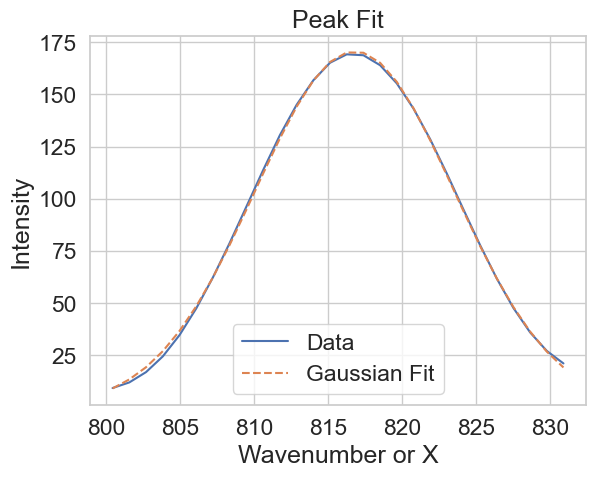

{'Amplitude': np.float64(170.66833830454075), 'Center': np.float64(816.7944451232049), 'Width (FWHM)': np.float64(15.855828170963775), 'Area': np.float64(2880.321150476945)}


In [98]:
# --- Example Usage ---
x = smoothed_df.columns[5:].astype(float)
y = smoothed_df.iloc[0, 5:].values
#print(f"x ranges from {x.min()} to {x.max()}")
results = fit_peaks(x, y, region=(800.451, 830.897))
print(results)

In [99]:
pd.DataFrame(results)

ValueError: If using all scalar values, you must pass an index

### Interactive plot


In [25]:
meta_cols = ['exp', 'sample', 'trt_time', 'orient', 'spectra_num']
spectral_start_col = 4
#wavenumbers = smoothed_df.columns.to_numpy(float)
spectral_cols = smoothed_df.iloc[:, 5:-1].columns#.difference(['exp', 'sample', 'trt_time', 'orient', 'combo'])
wavenumbers = np.array([float(col) for col in spectral_cols])

# ------------------------
# Create combo labels
# ------------------------
def combo_label(row):
    return f"{row['exp']}|{row['sample']}|{row['trt_time']}|{row['orient']}|{row['spectra_num']}"

smoothed_df['combo'] = smoothed_df[meta_cols].apply(combo_label, axis=1)
unique_combos = smoothed_df['combo'].unique()

# ------------------------
# Initialize Dash App
# ------------------------
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H2("Spectral Comparison Tool (Group A vs Group B)"),
    html.Div([
        html.Label("Select Group A"),
        dcc.Dropdown(id='dropdown-a', options=[{'label': c, 'value': c} for c in unique_combos],
                     value=unique_combos[0])
    ], style={'width': '45%', 'display': 'inline-block'}),

    html.Div([
        html.Label("Select Group B"),
        dcc.Dropdown(id='dropdown-b', options=[{'label': c, 'value': c} for c in unique_combos],
                     value=unique_combos[1])
    ], style={'width': '45%', 'display': 'inline-block', 'marginLeft': '5%'}),

    dcc.Graph(id='spectra-plot', style={"height": "700px"})
])

# ------------------------
# Callback to update plot
# ------------------------
@app.callback(
    Output('spectra-plot', 'figure'),
    Input('dropdown-a', 'value'),
    Input('dropdown-b', 'value')
)
def update_plot(combo_a, combo_b):
    fig = go.Figure()

    offset_b = 500

    # Group A
    subset_a = smoothed_df[smoothed_df['combo'] == combo_a]
    for _, row in subset_a.iterrows():
        y = row.iloc[spectral_start_col:-1].values.astype(float)
        fig.add_trace(go.Scatter(
            x=wavenumbers,
            y=y,
            mode='lines',
            line=dict(color='blue'),
            name=f"A: {combo_a}"
        ))

    # Group B (with offset)
    subset_b = smoothed_df[smoothed_df['combo'] == combo_b]
    for _, row in subset_b.iterrows():
        y = row.iloc[spectral_start_col:-1].values.astype(float) + offset_b
        fig.add_trace(go.Scatter(
            x=wavenumbers,
            y=y,
            mode='lines',
            line=dict(color='red'),
            name=f"B: {combo_b} (+{offset_b})"
        ))

    fig.update_layout(
        title=f"Group A: {combo_a} vs Group B: {combo_b}",
        xaxis_title="Wavenumber (cm⁻¹)",
        yaxis_title="Intensity (a.u.)",
        height=600,
        width=1100,
        template="plotly_white",
        xaxis = dict(
        tickmode = 'array', 
        tickvals = np.arange(800, 1750, 50),
        range = [800, 1750]
    )
    
    )
    return fig

# ------------------------
# Run the App
# ------------------------
if __name__ == '__main__':
    app.run(debug=True)


#### Peak Ratios

In [112]:
smoothed_df.iloc[:, 600:700].columns

Index(['1383.92', '1384.89', '1385.87', '1386.84', '1387.82', '1388.79',
       '1389.77', '1390.74', '1391.72', '1392.69', '1393.67', '1394.64',
       '1395.61', '1396.59', '1397.56', '1398.53', '1399.51', '1400.48',
       '1401.45', '1402.42', '1403.39', '1404.36', '1405.33', '1406.3',
       '1407.27', '1408.24', '1409.21', '1410.18', '1411.15', '1412.12',
       '1413.09', '1414.06', '1415.03', '1416', '1416.96', '1417.93', '1418.9',
       '1419.86', '1420.83', '1421.8', '1422.76', '1423.73', '1424.69',
       '1425.66', '1426.62', '1427.59', '1428.55', '1429.52', '1430.48',
       '1431.44', '1432.41', '1433.37', '1434.33', '1435.3', '1436.26',
       '1437.22', '1438.18', '1439.14', '1440.1', '1441.06', '1442.03',
       '1442.99', '1443.95', '1444.91', '1445.87', '1446.82', '1447.78',
       '1448.74', '1449.7', '1450.66', '1451.62', '1452.57', '1453.53',
       '1454.49', '1455.45', '1456.4', '1457.36', '1458.32', '1459.27',
       '1460.23', '1461.18', '1462.14', '1463.09',

In [134]:
smoothed_df.iloc[:, 850:900].columns

Index(['1619.75', '1620.66', '1621.57', '1622.48', '1623.39', '1624.29',
       '1625.2', '1626.11', '1627.02', '1627.93', '1628.84', '1629.74',
       '1630.65', '1631.56', '1632.47', '1633.37', '1634.28', '1635.19',
       '1636.09', '1637', '1637.9', '1638.81', '1639.71', '1640.62', '1641.52',
       '1642.43', '1643.33', '1644.23', '1645.14', '1646.04', '1646.94',
       '1647.84', '1648.75', '1649.65', '1650.55', '1651.45', '1652.35',
       '1653.26', '1654.16', '1655.06', '1655.96', '1656.86', '1657.76',
       '1658.66', '1659.55', '1660.45', '1661.35', '1662.25', '1663.15',
       '1664.05'],
      dtype='object')

In [116]:
smoothed_df['trt_time'].unique()

array(['20mins', '24h', '2mins', '40mins', '60mins', '20mins24h',
       '2mins24h', '40mins24h', '60mins24h'], dtype=object)

In [135]:
pk_ratio = pd.DataFrame(smoothed_df['1663.15']/smoothed_df['1450.66'], columns = ['ratio'])
ratio_df = pd.concat([df.iloc[:, :4], pk_ratio], axis=1)
ratio_df.head()

sample trt_time orient  spectra_num     ratio
0   Ctrl   20mins   Orth            1  0.195292
1   Ctrl   20mins   Orth            2  0.295239
2   Ctrl   20mins   Orth            3  0.493274
3   Ctrl   20mins   Orth            4  0.495952
4   Ctrl   20mins   Orth            5  0.401380

In [136]:
ratio_df[(ratio_df['trt_time'] == '40mins') & (ratio_df['sample'] == 'Trt')]

sample trt_time orient  spectra_num     ratio
126    Trt   40mins   Orth            1  0.244963
127    Trt   40mins   Orth            2  0.253808
128    Trt   40mins   Orth            4  0.263932
129    Trt   40mins   Orth            5  0.215895
130    Trt   40mins   Orth            6  0.188893
131    Trt   40mins   Para            1  0.410388
132    Trt   40mins   Para            2  0.632650
133    Trt   40mins   Para            3  0.541433
134    Trt   40mins   Para            4  0.702838
135    Trt   40mins   Para            5  0.515216

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_2620\2223017718.py:3: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_2620\2223017718.py:3: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


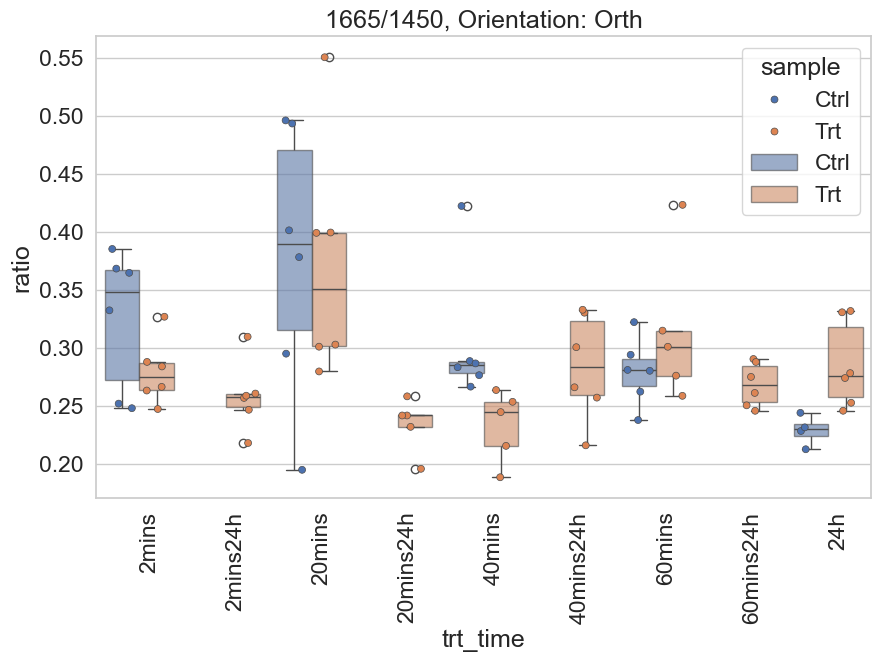

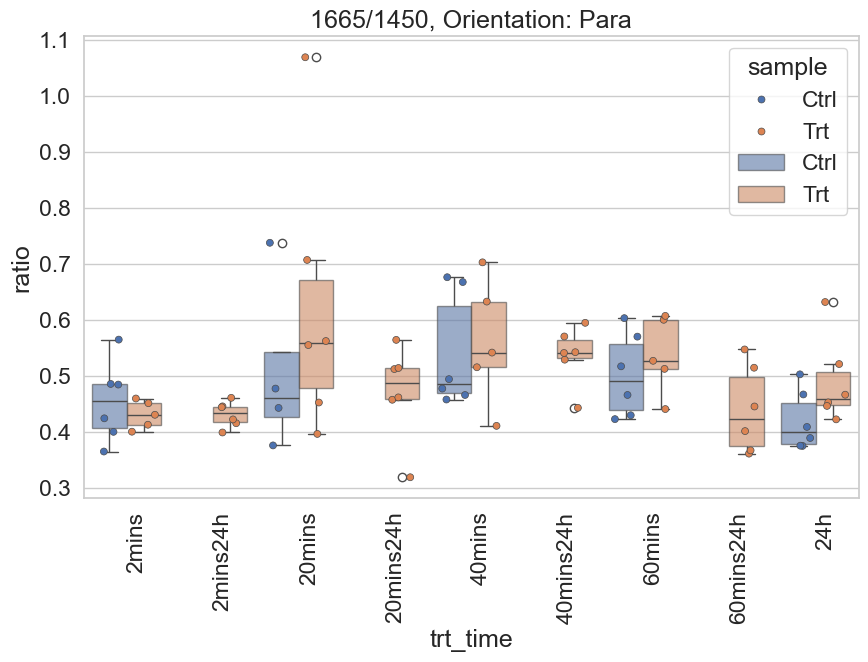

In [137]:
for x in df['orient'].unique():
    plt.figure(figsize = (10,6));
    sns.stripplot(
        x = 'trt_time',
        y = 'ratio',
        data = ratio_df[ratio_df['orient'] == x],
        hue = 'sample',
        order = ['2mins', '2mins24h','20mins','20mins24h','40mins', '40mins24h','60mins', '60mins24h', '24h'],
        jitter = .3,
        dodge = True,
        edgecolor = 'gray',
        linewidth = .5
    );
    sns.boxplot(
        x = 'trt_time',
        y = 'ratio',
        data = ratio_df[ratio_df['orient'] == x],
        hue = 'sample',
        order = ['2mins', '2mins24h','20mins','20mins24h','40mins', '40mins24h','60mins', '60mins24h', '24h'],
        boxprops=dict(alpha=.6)
        #jitter = .3,
        #dodge = True
    );
    plt.xticks(rotation = 90, ha = 'left');
    plt.title(f'1665/1450, Orientation: {x}');

In [103]:
def baseline_correct_spectrum(y, method='arpls', lam=1e5):
    baseline_fitter = Baseline()
    # pybaselines returns (baseline, params)
    baseline, _ = getattr(baseline_fitter, method)(y, lam=lam)
    return baseline

def baseline_correct_dataframe(df, method='arpls', lam=1e5):
    corrected = []
    for idx, row in df.iterrows():
        y = np.asarray(row.values, dtype=np.float64)
        baseline = baseline_correct_spectrum(y, method=method, lam=lam)
        corrected.append(y - baseline)
    return pd.DataFrame(corrected, columns=df.columns, index=df.index)


In [104]:
corrected_df = baseline_correct_dataframe(df = df.iloc[:, 4:], method = 'arpls', lam = 1e5)

In [73]:
df.columns[600:700]

Index(['1384.42', '1385.4', '1386.37', '1387.35', '1388.33', '1389.3',
       '1390.28', '1391.25', '1392.23', '1393.2', '1394.18', '1395.15',
       '1396.12', '1397.1', '1398.07', '1399.04', '1400.02', '1400.99',
       '1401.96', '1402.93', '1403.91', '1404.88', '1405.85', '1406.82',
       '1407.79', '1408.76', '1409.73', '1410.7', '1411.67', '1412.64',
       '1413.61', '1414.58', '1415.55', '1416.51', '1417.48', '1418.45',
       '1419.42', '1420.38', '1421.35', '1422.32', '1423.29', '1424.25',
       '1425.22', '1426.18', '1427.15', '1428.11', '1429.08', '1430.04',
       '1431.01', '1431.97', '1432.93', '1433.9', '1434.86', '1435.82',
       '1436.79', '1437.75', '1438.71', '1439.67', '1440.63', '1441.6',
       '1442.56', '1443.52', '1444.48', '1445.44', '1446.4', '1447.36',
       '1448.32', '1449.28', '1450.24', '1451.19', '1452.15', '1453.11',
       '1454.07', '1455.03', '1455.98', '1456.94', '1457.9', '1458.85',
       '1459.81', '1460.77', '1461.72', '1462.68', '1463.63'

In [72]:
base_df = pd.concat([df.iloc[:, :3], corrected_df], axis=1)
base_df.to_csv('20250429-0501.csv', index = False)

In [87]:
df#.iloc[:, 4:]

exp  Unnamed: 0 sample trt_time orient    752.673    753.817  \
0    20250609           0   Ctrl   20mins   Orth  20.135100  26.775000   
1    20250609           1   Ctrl   20mins   Orth  20.984000  28.009200   
2    20250609           2   Ctrl   20mins   Orth  15.713000  20.535500   
3    20250609           3   Ctrl   20mins   Orth  21.460000  23.165300   
4    20250609           4   Ctrl   20mins   Orth  32.671100  35.894400   
..        ...         ...    ...      ...    ...        ...        ...   
180  20250609         180    Trt   60mins   Orth  19.462000  23.893300   
181  20250609         181    Trt   60mins   Para  12.563300  13.349400   
182  20250609         182    Trt   60mins   Para   0.000682   0.001352   
183  20250609         183    Trt   60mins   Para   4.612630   6.664990   
184  20250609         184    Trt   60mins   Para   3.795820   4.825130   

        754.96    756.103    757.245  ...   1769.39   1770.26   1771.13  \
0    34.650500  43.324100  52.080000  ...   6.33526   5.81454   5.31166   
1    36.107500  44.811100  53.448900  ...   2.83330   3.43919   4.68539   
2    26.208900  32.671400  39.783700  ...   6.77675   7.19366   7.60113   
3    25.098300  27.293100  29.784900  ...   7.92459   7.58894   7.27984   
4    39.578600  43.782200  48.553100  ...   8.46996   7.65848   6.99847   
..         ...        ...        ...  ...       ...       ...       ...   
180  28.753300  33.917500  39.214900  ...  16.62150  15.43090  14.27590   
181  13.984000  14.441900  14.704900  ...  20.10860  19.49810  18.81650   
182   0.002615   0.004933   0.009074  ...  13.61400  14.13750  14.02400   
183   8.854310  10.817000  12.156500  ...  11.92670  11.55570  11.16790   
184   6.067330   7.547030   9.285070  ...  11.57470  10.93900  10.31100   

         1772   1772.86   1773.73    1774.6   1775.46   1776.33   1777.19  
0     4.83020   4.37220   3.93975   3.53344   3.15475   2.80343   2.48005  
1     6.52050   8.71086  10.83640  12.39390  12.95720  12.35320  10.72970  
2     7.99417   8.36856   8.71968   9.04386   9.33650   9.59437   9.81366  
3     6.99502   6.73190   6.48850   6.26251   6.05263   5.85700   5.67463  
4     6.46199   6.02253   5.65910   5.35454   5.09669   4.87545   4.68382  
..        ...       ...       ...       ...       ...       ...       ...  
180  13.16320  12.09600  11.07840  10.11110   9.19769   8.33768   7.53306  
181  18.07350  17.27820  16.44080  15.56980  14.67630  13.76830  12.85660  
182  13.18990  11.70970   9.78792   7.68892   5.67353   3.92850   2.55380  
183  10.76600  10.35230   9.92948   9.49935   9.06499   8.62800   8.19139  
184   9.69423   9.09079   8.50331   7.93274   7.38175   6.85085   6.34209  

[185 rows x 1029 columns]

In [90]:
norm = df.iloc[:, 5:].div(df['1455.6'], axis=0)#dt.iloc[:, 5:].sum(axis=1)
dt_norm = pd.concat([df.iloc[:, :5], norm], axis=1)
#dt_norm = dt_norm.drop(dt_norm.index[113:119])

In [95]:
# Difference of Treated and Final Treated
df_mean = dt_norm.groupby(['exp', 'sample', 'trt_time', 'orient']).mean().reset_index()

diff = []
diff_final = []
for orient in ['Para', 'Orth']:
    for x in ['2mins','20mins','40mins', '60mins', '24h']:#
        dif = df_mean[(df_mean['orient'] == orient) & (df_mean['trt_time']==x)].iloc[1, 4:] - df_mean[(df_mean['orient'] == orient) & (df_mean['trt_time']==x)].iloc[0, 4:]
        #dif_24h = df_mean[(df_mean['orient'] == orient) & (df_mean['trt_time'].isin([x, f'{x}24h']))].iloc[2, 3:]-df_mean[(df_mean['orient'] == orient) & (df_mean['trt_time'].isin([x, f'{x}24h']))].iloc[0, 3:]
        diff.append({'trt_time': x, 'orient': orient, 'd': dif.values})
        #diff_final.append({'trt_time': x, 'orient': orient, 'd': dif_24h.values})


diff_df = pd.DataFrame(diff)
#diff_dff = pd.DataFrame(diff_final)

df_diff = pd.concat([diff_df.iloc[:, :2], diff_df['d'].apply(pd.Series)], axis = 1)
#dff_diff = pd.concat([diff_dff.iloc[:, :2], diff_dff['d'].apply(pd.Series)], axis = 1)

df_diff.columns = ['trt_time','orient'] + df_mean.iloc[:, 4:].columns.tolist()
#dff_diff.columns = ['trt_time','orient'] + df_mean.iloc[:, 3:].columns.tolist()

df_diff.insert(0, 'sample', ['diff']*len(df_diff))
#dff_diff.insert(0, 'sample', ['diff_final']*len(df_diff))
#pd.DataFrame(diff)

sub_dff =pd.concat([df_diff])#, dff_diff
sub_dff.head()

sample trt_time orient   752.673   753.817    754.96   756.103   757.245  \
0   diff    2mins   Para  2.959591  0.015568  0.016327  0.013619  0.006585   
1   diff   20mins   Para  3.085969  0.014061  0.023214  0.033070  0.041835   
2   diff   40mins   Para  0.514848  0.021322  0.016443  0.010478  0.004435   
3   diff   60mins   Para -5.714876 -0.015344 -0.025887 -0.038031 -0.050809   
4   diff      24h   Para  3.963192  0.033771  0.037155  0.042612  0.051251   

    758.388    759.53  ...   1769.39   1770.26   1771.13      1772   1772.86  \
0 -0.003544 -0.013578  ...  0.002523  0.001812  0.000950 -0.000028 -0.001087   
1  0.050706  0.060424  ...  0.016474  0.019262  0.023625  0.027934  0.033797   
2 -0.000687 -0.004228  ...  0.071781  0.071339  0.069513  0.066221  0.061664   
3 -0.063335 -0.074912  ...  0.062428  0.062067  0.061304  0.059673  0.056912   
4  0.061122  0.066834  ...  0.041836  0.040167  0.038486  0.036839  0.035257   

    1773.73    1774.6   1775.46   1776.33   1777.19  
0 -0.002188 -0.003295 -0.004370 -0.005381 -0.006300  
1  0.036945  0.034842  0.036166  0.035937  0.035017  
2  0.056274  0.050568  0.045041  0.040026  0.035695  
3  0.053178  0.048913  0.044611  0.040620  0.037121  
4  0.033767  0.032383  0.031117  0.029968  0.028934  

[5 rows x 1027 columns]

In [96]:
df_diff = pd.concat([dt_norm, sub_dff], axis=0)
df_sam = df_diff.melt(id_vars=['exp', 'sample', 'trt_time', 'orient'])#.drop(['sample'], axis=1)
#[dt['sample'] == 'Micetail_Ribo0.5_pre']
df_sam[["variable", "value"]] = df_sam[["variable", "value"]].astype('float64')
df_sam.head()

exp sample trt_time orient  variable    value
0  20250609   Ctrl   20mins   Orth   752.673  20.1351
1  20250609   Ctrl   20mins   Orth   752.673  20.9840
2  20250609   Ctrl   20mins   Orth   752.673  15.7130
3  20250609   Ctrl   20mins   Orth   752.673  21.4600
4  20250609   Ctrl   20mins   Orth   752.673  32.6711

In [109]:
# create offsets for each treatment group, exept the pbs
group_offsets = {
    '2mins': 0.0,
    #'Trt': 1.5,
    '20mins': 2,
    '40mins': 4.0,
    '60mins': 6.0,
    '24h':8,
    '2min24h': 0.5,
    #'Trt': 1.5,
    '20min24h': 2.5,
    '40min24h': 4.5,
    '60min24h': 6.5,
    
    
}
#'22mins': 5.7,
#    '27mins': 6.7,
 #   '32mins': 7.7
#make a copy of the dataframe
df_sam_spectra = df_sam.copy()
# add the defined offset value for each group
for group, offset in group_offsets.items():
    df_sam_spectra.loc[df_sam_spectra['trt_time']== group, 'value'] += offset

In [105]:
df_sam['trt_time'].unique()

array(['20mins', '24h', '2mins', '40mins', '60mins', '20min24h',
       '2min24h', '40min24h', '60min24h'], dtype=object)

In [10]:
df_sam_spectra['sample'].unique()

array(['Ctrl', 'Trt_final', 'Trt', 'diff'], dtype=object)

In [119]:

fig = px.line(
    df_sam_spectra[(df_sam_spectra['sample']=='Ctrl') & (df_sam_spectra['orient'] =='Para')],# ,'Trt'
    x="variable", y="value", 
              color="trt_time",
              #symbol =  'orient',
              category_orders={'trt_time': ['2mins', '2min24h','20mins','20min24h','40mins', '40min24h','60mins', '60min24h', '24h']}
              )
fig.update_traces(line=dict(width=1))
fig.update_layout(
    width=1200,  # Sets the width of the plot to 800 pixels
    height=900, # Sets the height of the plot to 600 pixels
    xaxis_range = [790, 1700],
    yaxis_range = [-1, 10]
)
fig.show()

In [121]:
fig.write_html("Parallel_Ctrl.html")

In [8]:
df

exp sample trt_time orient    752.673    753.817     754.96  \
0    20250609   Ctrl   20mins   Orth  20.135100  26.775000  34.650500   
1    20250609   Ctrl   20mins   Orth  20.984000  28.009200  36.107500   
2    20250609   Ctrl   20mins   Orth  15.713000  20.535500  26.208900   
3    20250609   Ctrl   20mins   Orth  21.460000  23.165300  25.098300   
4    20250609   Ctrl   20mins   Orth  32.671100  35.894400  39.578600   
..        ...    ...      ...    ...        ...        ...        ...   
180  20250609    Trt   60mins   Orth  19.462000  23.893300  28.753300   
181  20250609    Trt   60mins   Para  12.563300  13.349400  13.984000   
182  20250609    Trt   60mins   Para   0.000682   0.001352   0.002615   
183  20250609    Trt   60mins   Para   4.612630   6.664990   8.854310   
184  20250609    Trt   60mins   Para   3.795820   4.825130   6.067330   

       756.103    757.245   758.388  ...   1769.39   1770.26   1771.13  \
0    43.324100  52.080000  60.07780  ...   6.33526   5.81454   5.31166   
1    44.811100  53.448900  61.28700  ...   2.83330   3.43919   4.68539   
2    32.671400  39.783700  47.34980  ...   6.77675   7.19366   7.60113   
3    27.293100  29.784900  32.61540  ...   7.92459   7.58894   7.27984   
4    43.782200  48.553100  53.93010  ...   8.46996   7.65848   6.99847   
..         ...        ...       ...  ...       ...       ...       ...   
180  33.917500  39.214900  44.44930  ...  16.62150  15.43090  14.27590   
181  14.441900  14.704900  14.76450  ...  20.10860  19.49810  18.81650   
182   0.004933   0.009074   0.01629  ...  13.61400  14.13750  14.02400   
183  10.817000  12.156500  12.58020  ...  11.92670  11.55570  11.16790   
184   7.547030   9.285070  11.30210  ...  11.57470  10.93900  10.31100   

         1772   1772.86   1773.73    1774.6   1775.46   1776.33   1777.19  
0     4.83020   4.37220   3.93975   3.53344   3.15475   2.80343   2.48005  
1     6.52050   8.71086  10.83640  12.39390  12.95720  12.35320  10.72970  
2     7.99417   8.36856   8.71968   9.04386   9.33650   9.59437   9.81366  
3     6.99502   6.73190   6.48850   6.26251   6.05263   5.85700   5.67463  
4     6.46199   6.02253   5.65910   5.35454   5.09669   4.87545   4.68382  
..        ...       ...       ...       ...       ...       ...       ...  
180  13.16320  12.09600  11.07840  10.11110   9.19769   8.33768   7.53306  
181  18.07350  17.27820  16.44080  15.56980  14.67630  13.76830  12.85660  
182  13.18990  11.70970   9.78792   7.68892   5.67353   3.92850   2.55380  
183  10.76600  10.35230   9.92948   9.49935   9.06499   8.62800   8.19139  
184   9.69423   9.09079   8.50331   7.93274   7.38175   6.85085   6.34209  

[185 rows x 1028 columns]

In [23]:
df[(df['sample'] == 'Ctrl') & (df['trt_time'] == '20mins') & (df['orient'] == 'Orth')]#.iloc[:, 4:]

exp sample trt_time orient  752.673  753.817   754.96  756.103  \
0  20250609   Ctrl   20mins   Orth  20.1351  26.7750  34.6505  43.3241   
1  20250609   Ctrl   20mins   Orth  20.9840  28.0092  36.1075  44.8111   
2  20250609   Ctrl   20mins   Orth  15.7130  20.5355  26.2089  32.6714   
3  20250609   Ctrl   20mins   Orth  21.4600  23.1653  25.0983  27.2931   
4  20250609   Ctrl   20mins   Orth  32.6711  35.8944  39.5786  43.7822   
5  20250609   Ctrl   20mins   Orth  18.4693  21.3608  25.4078  31.3033   
6  20250609   Ctrl   20mins   Orth  23.7015  28.1148  32.9722  38.2314   

   757.245  758.388  ...   1769.39   1770.26   1771.13      1772   1772.86  \
0  52.0800  60.0778  ...   6.33526   5.81454   5.31166   4.83020   4.37220   
1  53.4489  61.2870  ...   2.83330   3.43919   4.68539   6.52050   8.71086   
2  39.7837  47.3498  ...   6.77675   7.19366   7.60113   7.99417   8.36856   
3  29.7849  32.6154  ...   7.92459   7.58894   7.27984   6.99502   6.73190   
4  48.5531  53.9301  ...   8.46996   7.65848   6.99847   6.46199   6.02253   
5  40.0325  52.0819  ...  15.56220  16.15090  16.43700  16.09960  15.09340   
6  43.8243  49.6730  ...  16.12320  15.83260  15.38680  14.79930  14.08680   

    1773.73    1774.6   1775.46   1776.33   1777.19  
0   3.93975   3.53344   3.15475   2.80343   2.48005  
1  10.83640  12.39390  12.95720  12.35320  10.72970  
2   8.71968   9.04386   9.33650   9.59437   9.81366  
3   6.48850   6.26251   6.05263   5.85700   5.67463  
4   5.65910   5.35454   5.09669   4.87545   4.68382  
5  13.68600  12.20950  10.87400   9.74768   8.82692  
6  13.27030  12.37060  11.41280  10.41890   9.41329  

[7 rows x 1028 columns]

In [184]:
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# -----------------------------
# Peak Fitting Function
# -----------------------------
def fit_peak(x, y, center_guess, window=30):
    # Crop data around the peak
    mask = (x > center_guess - window) & (x < center_guess + window)
    x_crop = x[mask]
    y_crop = y[mask]

    if len(x_crop) < 5:
        return None
    
    try:
        # Initial guess: amplitude, center, width
        p0 = [np.max(y_crop), center_guess, 5]
        popt, _ = curve_fit(gaussian, x_crop, y_crop, p0=p0)
        return popt  # a, x0, sigma
    except RuntimeError:
        return None

In [185]:
o_put = []
for x in df['sample'].unique():
    for y in df['trt_time'].unique():
        for z in df['orient'].unique():
            # -----------------------------
            # Simulate or Load Spectra
            # -----------------------------

            dx = df[(df['sample'] == x) & (df['trt_time'] == y) & (df['orient'] == z)]
            xx = dx.iloc[:, 4:].columns.astype('float64').to_numpy()
            spectra = dx.iloc[:, 4:].to_numpy()
            fit_window = 40
            true_peaks = [815, 855, 870, 920, 940,  
                        1003, 1243, 1270,  1635, 1664]  # Expected peak regions (center positions)
            #762, 783, 1425,#1166,1395, 970,1096,1034,1053,  1062,  1128,  
            #1205, 1223,1322, 1343, 1374, 
                       #  1439, 1450, 1488,

            # -----------------------------
            # Fit All Spectra
            # -----------------------------
            results = {pk: [] for pk in true_peaks}
            details = [f'{x}_{y}_{z}']
            

            for yy in spectra:
                for pk in true_peaks:
                    fit = fit_peak(xx, yy, pk, window = fit_window)
                    if fit is not None:
                        results[pk].append(fit[1])  # x0 (peak position)
                    else:
                        results[pk].append(np.nan)

            # -----------------------------
            # Output Mean Peak Positions
            # -----------------------------
            df_peak = pd.DataFrame(results)
            df_peak.insert(0, 'details', [details]*len(df_peak))
            o_put.append(df_peak)
            #mean_positions = df_peak.mean()
            #position_std = df_peak.std()
            '''print("\n📊 Mean Peak Positions:")
            print(mean_positions)
            print(position_std)'''



In [186]:
peak_df = pd.concat(o_put)
peak_df = pd.concat([pd.DataFrame(peak_df['details'].to_list(), columns=['details']).reset_index(drop = True), peak_df.iloc[:, 1:].reset_index(drop = True)], axis=1)

In [187]:
deets = peak_df['details'].str.split('_', expand = True)
deets.columns = ['sample', 'trt_time', 'orient']
deets
peak_df = pd.concat([deets, peak_df.iloc[:, 1:]], axis=1)

In [188]:
pk_df_long = peak_df.melt(id_vars=['sample', 'trt_time', 'orient'],
             )
pk_df_long['variable'] = pk_df_long['variable'].astype('int')

(1.5, 6.5)

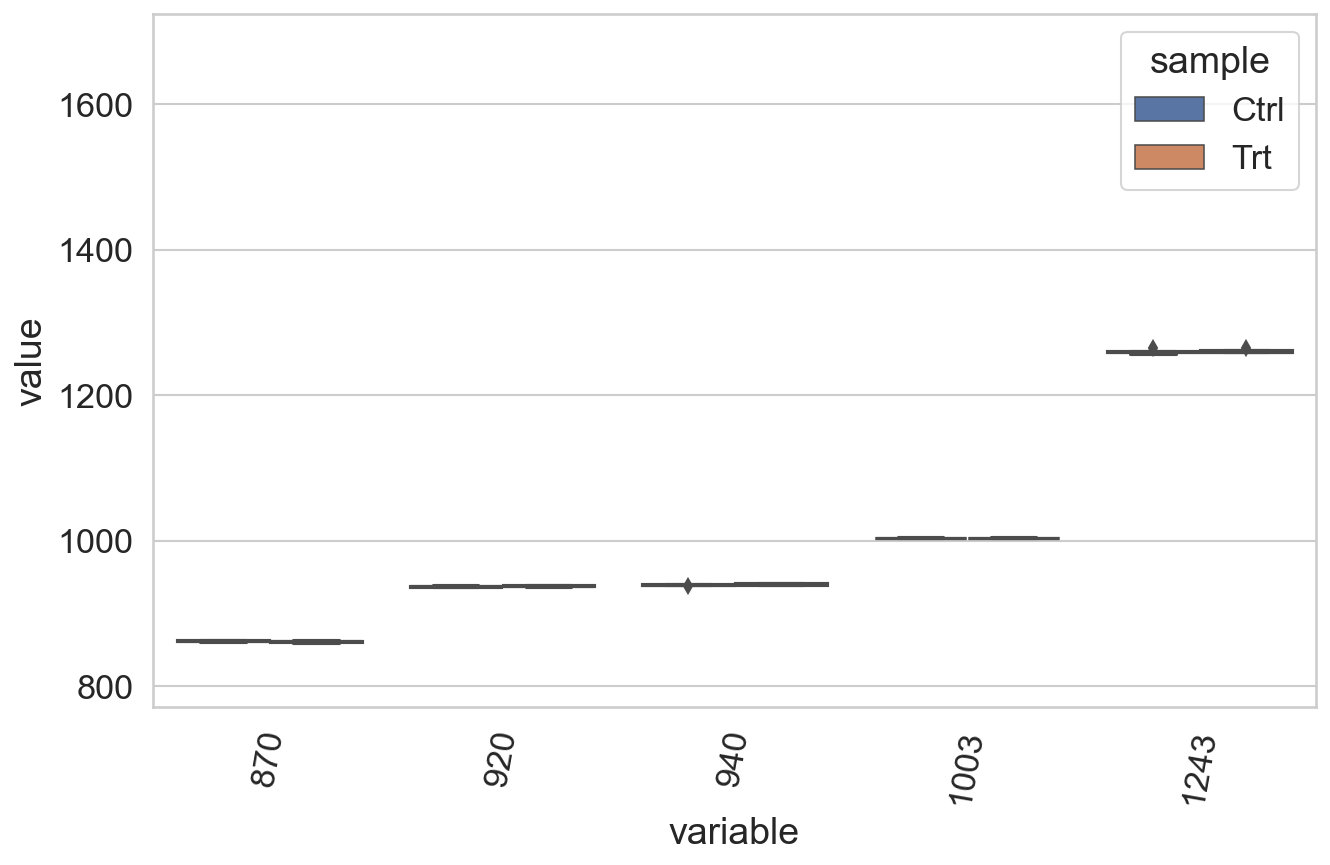

In [190]:
plt.figure(figsize=(10, 6), dpi = 150)
sns.boxplot(
    data = pk_df_long[(pk_df_long['trt_time']=='60mins') & (pk_df_long['orient'] == 'Para')], #& (pk_df_long['value'] <= 1000)
    x = 'variable',
    y = 'value',
    hue = 'sample'
)
plt.xticks(rotation = 80, ha = 'center');
#plt.ylim([750, 1000])
plt.xlim([1.5, 6.5])
#plt.yscale('log')

In [195]:
peak_df[peak_df['trt_time'].str.contains('40min')].groupby(['orient', 'sample', 'trt_time', ]).mean().T

orient           Orth                                   Para               \
sample           Ctrl          Trt                      Ctrl          Trt   
trt_time       40mins     40min24h       40mins       40mins     40min24h   
815        816.804381   816.563346   816.609774   816.278348   816.144289   
855        861.622695   862.275208   861.803544   861.688279   862.411929   
870        861.889024   862.590991   862.086362   862.036525   862.926651   
920        940.642847   941.067073   940.650390   937.645060   938.092201   
940        943.570676   944.258918   944.054538   939.688746   940.583653   
1003      1004.041548  1004.648354  1004.942264  1004.099780  1004.112569   
1243      1249.306558  1249.654966  1249.036502  1253.512056  1250.376210   
1270      1248.111049  1248.423722  1247.603316  1250.234213  1247.851685   
1635      1658.297104  1665.796565  1659.704448  1666.972275  1666.644914   
1664      1655.738611  1657.310572  1655.366517  1659.475308  1658.461803   

orient                 
sample                 
trt_time       40mins  
815        814.843293  
855        861.797246  
870        864.757332  
920        958.414650  
940        941.741933  
1003      1004.188243  
1243      1253.831503  
1270      1248.904201  
1635      1660.778876  
1664      1655.230780

In [196]:
peak_df[peak_df['trt_time'].str.contains('40min')].groupby(['orient', 'sample', 'trt_time', ]).std().T

orient        Orth                           Para                     
sample        Ctrl        Trt                Ctrl       Trt           
trt_time    40mins   40min24h    40mins    40mins  40min24h     40mins
815       0.831561   0.718519  0.370262  0.856690  0.972179   0.587263
855       0.417529   0.530467  0.626488  0.479184  0.785558   2.555183
870       0.428207   0.532434  0.640017  0.440770  0.748126   2.633467
920       0.251293   0.354286  0.394522  0.757044  0.853696  38.445362
940       0.267790   0.661286  0.724757  1.180381  0.943471   1.740181
1003      0.225123   0.212941  0.408837  0.609662  0.621698   0.489209
1243      0.829802   1.024121  1.921785  4.047067  4.092104   2.550683
1270      0.759544   1.164644  1.354776  5.165078  3.988400   6.259209
1635      1.251744  10.750723  5.233817  5.083828  5.099413   5.802407
1664      1.651004   3.429258  2.315953  1.546017  1.624706   2.289529

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_21116\1083038510.py:86: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\oadeji01\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


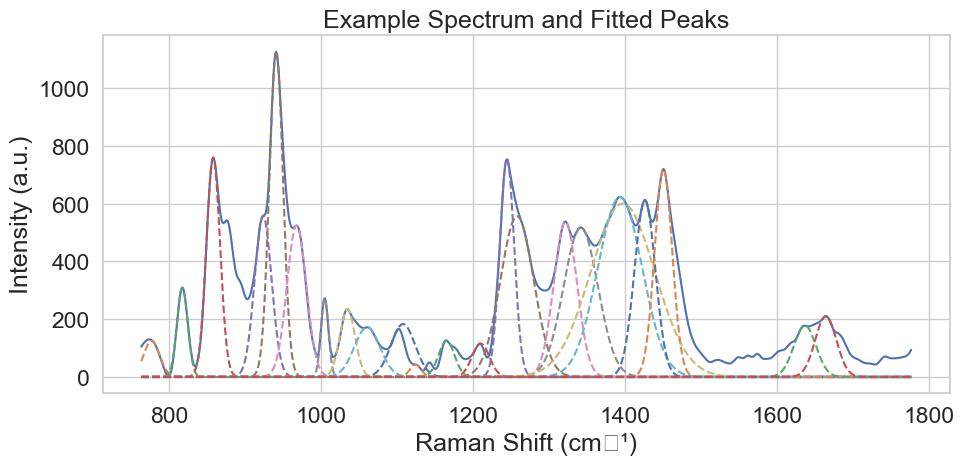

In [360]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# -----------------------------
# Define a Gaussian function
# -----------------------------
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# -----------------------------
# Simulate or Load Spectra
# -----------------------------

x = smoothed_df.iloc[:, 5:].columns.astype('float64').to_numpy()
spectra = smoothed_df[(smoothed_df['sample'] == 'Ctrl') & (smoothed_df['trt_time'] == '2mins') & (smoothed_df['orient'] == 'Orth')].iloc[:, 5:].to_numpy()
fit_window = 40
true_peaks = [762, 783, 815, 855, 870, 920, 940, 970, 
              1003, 1034, 1053,  1062, 1096, 1128, 1166, 
              1205, 1223, 1243, 1270, 1322, 1343, 1374, 
              1395, 1425, 1439, 1450, 1488, 1635, 1664]  # Expected peak regions (center positions)


# -----------------------------
# Peak Fitting Function
# -----------------------------
def fit_peak(x, y, center_guess, window=5):
    # Crop data around the peak
    mask = (x > center_guess - window) & (x < center_guess + window)
    x_crop = x[mask]
    y_crop = y[mask]

    if len(x_crop) < 5:
        return None
    
    try:
        # Initial guess: amplitude, center, width
        p0 = [np.max(y_crop), center_guess, 10]
        popt, _ = curve_fit(gaussian, x_crop, y_crop, p0=p0)
        return popt  # a, x0, sigma
    except RuntimeError:
        return None

# -----------------------------
# Fit All Spectra
# -----------------------------
results = {f"peak_{pk}": [] for pk in true_peaks}

for y in spectra:
    for pk in true_peaks:
        fit = fit_peak(x, y, pk, window = fit_window)
        if fit is not None:
            results[f"peak_{pk}"].append(fit[1])  # x0 (peak position)
        else:
            results[f"peak_{pk}"].append(np.nan)

# -----------------------------
# Output Mean Peak Positions
# -----------------------------
smoothed_df_peak = pd.DataFrame(results)
mean_positions = smoothed_df_peak.mean()
position_std = smoothed_df_peak.std()
'''print("\n📊 Mean Peak Positions:")
print(mean_positions)
print(position_std)'''

peak_pos = pd.DataFrame(mean_positions, columns = ['mean'])
peak_pos.insert(1, 'std', position_std)


# -----------------------------
# Plot Example Fit
# -----------------------------
plt.figure(figsize=(10, 5))
y_example = spectra[0]
plt.plot(x, y_example, label='Spectrum')
for pk in true_peaks:
    fit = fit_peak(x, y_example, pk)
    if fit is not None:
        plt.plot(x, gaussian(x, *fit), '--', label=f'Fit near {pk} cm⁻¹')
plt.xlabel('Raman Shift (cm⁻¹)')
plt.ylabel('Intensity (a.u.)')
plt.title('Example Spectrum and Fitted Peaks')
#plt.legend()
plt.tight_layout()
plt.show()         
            






ValueError: x and y must have same first dimension, but have shapes (1,) and (1024,)

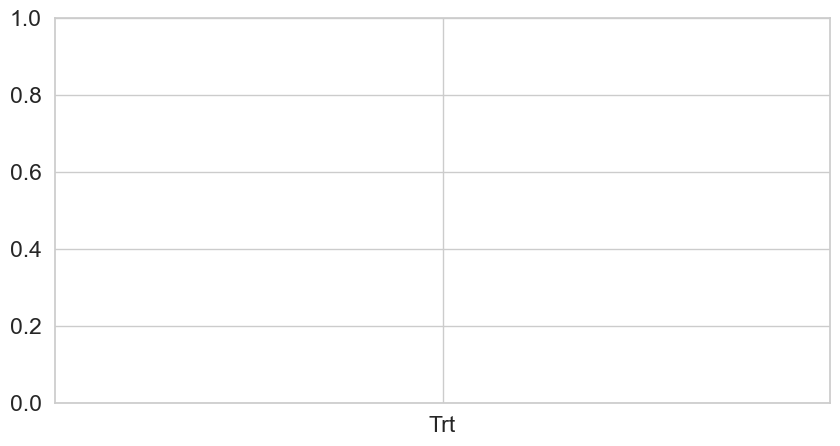

In [96]:
# -----------------------------
# Plot Example Fit
# -----------------------------
plt.figure(figsize=(10, 5))
y_example = spectra[0]
plt.plot(x, y_example, label='Spectrum')
for pk in true_peaks:
    fit = fit_peak(x, y_example, pk)
    if fit is not None:
        plt.plot(x, gaussian(x, *fit), '--', label=f'Fit near {pk} cm⁻¹')
plt.xlabel('Raman Shift (cm⁻¹)')
plt.ylabel('Intensity (a.u.)')
plt.title('Example Spectrum and Fitted Peaks')
#plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# -----------------------------
# Export Mean Peak Positions to CSV
# -----------------------------
mean_positions.to_csv("mean_peak_positions.csv", header=["Mean Position (cm⁻¹)"])
position_std.to_csv("peak_position_std.csv")
#print("\n✅ Mean peak positions saved to 'mean_peak_positions.csv'")

In [19]:
peak_pos = pd.DataFrame(mean_positions, columns = ['mean'])
peak_pos.insert(1, 'std', position_std)


<ErrorbarContainer object of 3 artists>

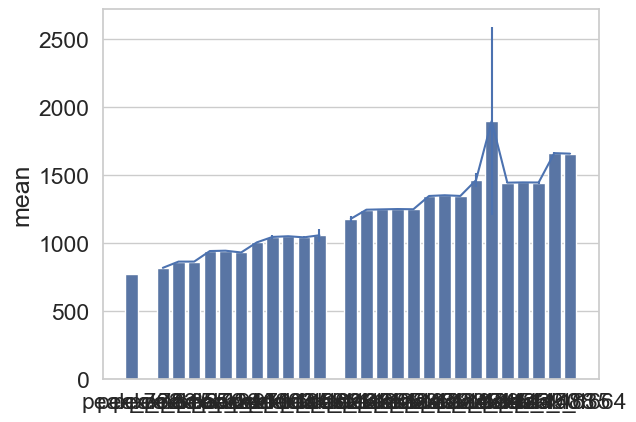

In [30]:
sns.barplot(
    data = peak_pos,
    x = peak_pos.index.to_numpy(),
    y = 'mean'
)
plt.errorbar(
    x = peak_pos.index.to_numpy(),
    y = peak_pos['mean'],
    yerr=peak_pos['std']
)

<Axes: ylabel='mean'>

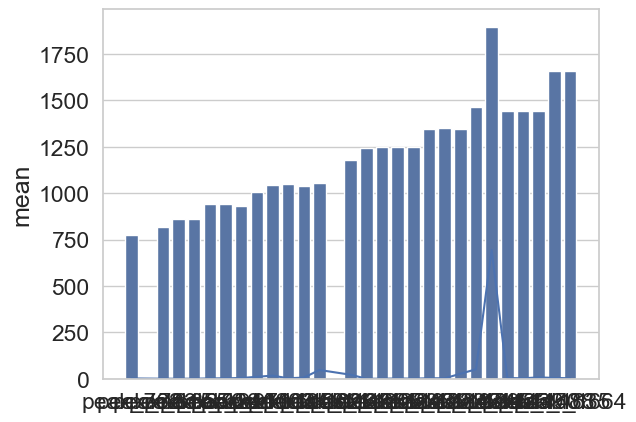

In [26]:
sns.barplot(
    data = peak_pos,
    x = peak_pos.index.to_numpy(),
    y = 'mean'
)
sns.lineplot(
    data = peak_pos,
    x = peak_pos.index.to_numpy(),
    y = 'std'
)

In [23]:
peak_pos#.index

mean         std
peak_762    772.694497    1.876759
peak_783           NaN         NaN
peak_815    816.329893    0.574886
peak_855    862.034270    0.578647
peak_870    862.215752    0.599265
peak_920    939.798578    2.056230
peak_940    942.328306    2.631395
peak_970    929.305070    4.356921
peak_1003  1003.490011         NaN
peak_1034  1043.539497   17.133862
peak_1053  1048.780986    3.082164
peak_1062  1040.550634    6.314975
peak_1096  1055.812412   47.432443
peak_1128          NaN         NaN
peak_1166  1176.534303   21.859388
peak_1205  1243.894419    0.361306
peak_1223  1246.458419    0.376136
peak_1243  1248.703954    1.951388
peak_1270  1247.220978    0.808678
peak_1322  1344.800068    2.994472
peak_1343  1350.266217    2.737010
peak_1374  1345.057431         NaN
peak_1395  1461.251359   51.421093
peak_1425  1895.793348  693.495064
peak_1439  1442.778238    4.234956
peak_1450  1444.797587    2.769016
peak_1488  1443.897562    7.605799
peak_1635  1659.988910    4.728409
peak_1664  1656.130357    3.032034